In [1]:
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import scipy.io
import myTensorfunctions as mtf
from timeit import default_timer as timer
from scipy import signal
import myCumulantfunctions as mc
from tensorly.decomposition import parafac
from tensorly.decomposition import SymmetricCP
import sys
import seaborn as sns
import sympy as sp
import matplotlib.ticker as ticker
from matplotlib import rc


In [2]:
n_repeat = 100
seed_seq = [*range(n_repeat)]
Prange = [*range(4,11)]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

The code window below is used to import the saved data. The first part is to select the datasets and the second part is to divide all of the data into separate dictionaries. To select the dataset you wish to use un-comment the corresponding import dataset lines in the top part of the code.

In [65]:
from scipy.io import loadmat


# DATASET selection part
#-----------------------------------------------------------------------------------------------------------------
# CORRECT
#### For the no initalization, explicit HOSVD and explicit GEVD init schemes
# EYE_dict_init = loadmat('EYEinit_correct_dict.mat'); HOSVD_dict_init = loadmat('HOSVDinit_correct_dict.mat')
# GEVD_dict_init = loadmat('GEVDinit_correct_dict.mat'); IGEVD_dict_init = loadmat('IGEVDinit_correct_dict.mat')

#### For the explicit HOSVD, U-I-HOSVD and C-I-HOSVD schemes
# EYE_dict_init = loadmat('HOSVDinit_correct_dict.mat'); HOSVD_dict_init = loadmat('HOSVDinitHALF_correct_dict.mat')
# GEVD_dict_init = loadmat('HOSVDinitCORE_correct_dict.mat'); IGEVD_dict_init = loadmat('IGEVDinit_correct_dict.mat')

#### For the explicit GEVD, full I-GEVD, U-I-GEVD and C-I-GEVD schemes
EYE_dict_init = loadmat('GEVDinit_correct_dict.mat'); HOSVD_dict_init = loadmat('IGEVDinit_correct_dict.mat')
GEVD_dict_init = loadmat('IGEVDinitHALF_correct_dict.mat'); IGEVD_dict_init = loadmat('IGEVDinitCORE_correct_dict.mat')

#### For the no iniitalization, explicit HOSVD and explicit GEVD init schemes with only the smaller subtensor for measure of diagonality
# EYE_dict_init = loadmat('EYEinitDIAG_correct_dict.mat'); HOSVD_dict_init = loadmat('HOSVDinitDIAG_correct_dict.mat')
# GEVD_dict_init = loadmat('GEVDinitDIAG_correct_dict.mat'); IGEVD_dict_init = loadmat('IGEVDinit_correct_dict.mat')

#-----------------------------------------------------------------------------------------------------------------


FICA_niter = {}; QRT_niter = {}; ffIMP_niter = {}; ffFICA_niter = {}

FICA_niter[0] = EYE_dict_init['niter']['FICA']
QRT_niter[0]  = EYE_dict_init['niter']['QRT']
EYE_dict_init['niter']['ffIMP'][0][0] = EYE_dict_init['niter']['ffIMP'][0][0][:,0,:].squeeze() *EYE_dict_init['niter']['ffIMP'][0][0][:,1,:].squeeze()
ffIMP_niter[0]  = EYE_dict_init['niter']['ffIMP']
ffFICA_niter[0]  = EYE_dict_init['niter']['ffFICA']

FICA_niter[1] = HOSVD_dict_init['niter']['FICA']
QRT_niter[1]  = HOSVD_dict_init['niter']['QRT']
HOSVD_dict_init['niter']['ffIMP'][0][0] = HOSVD_dict_init['niter']['ffIMP'][0][0][:,0,:].squeeze() *HOSVD_dict_init['niter']['ffIMP'][0][0][:,1,:].squeeze()
ffIMP_niter[1]  = HOSVD_dict_init['niter']['ffIMP']
ffFICA_niter[1]  = HOSVD_dict_init['niter']['ffFICA']

FICA_niter[2] = GEVD_dict_init['niter']['FICA']
QRT_niter[2]  = GEVD_dict_init['niter']['QRT']
GEVD_dict_init['niter']['ffIMP'][0][0] = GEVD_dict_init['niter']['ffIMP'][0][0][:,0,:].squeeze() *GEVD_dict_init['niter']['ffIMP'][0][0][:,1,:].squeeze()
ffIMP_niter[2]  = GEVD_dict_init['niter']['ffIMP']
ffFICA_niter[2]  = GEVD_dict_init['niter']['ffFICA']

FICA_niter[3] = IGEVD_dict_init['niter']['FICA']
QRT_niter[3]  = IGEVD_dict_init['niter']['QRT']
IGEVD_dict_init['niter']['ffIMP'][0][0] = IGEVD_dict_init['niter']['ffIMP'][0][0][:,0,:].squeeze() *IGEVD_dict_init['niter']['ffIMP'][0][0][:,1,:].squeeze()
ffIMP_niter[3]  = IGEVD_dict_init['niter']['ffIMP']
ffFICA_niter[3]  = IGEVD_dict_init['niter']['ffFICA']

fail_FICA = {}; fail_QRT = {}; fail_ffIMP = {}; fail_ffFICA = {}

fail_FICA[0] = EYE_dict_init['fail']['FICA']
fail_QRT[0]  = EYE_dict_init['fail']['QRT']
fail_ffIMP[0]  = EYE_dict_init['fail']['ffIMP']
fail_ffFICA[0]  = EYE_dict_init['fail']['ffFICA']

fail_FICA[1] = HOSVD_dict_init['fail']['FICA']
fail_QRT[1]  = HOSVD_dict_init['fail']['QRT']
fail_ffIMP[1]  = HOSVD_dict_init['fail']['ffIMP']
fail_ffFICA[1]  = HOSVD_dict_init['fail']['ffFICA']

fail_FICA[2] = GEVD_dict_init['fail']['FICA']
fail_QRT[2]  = GEVD_dict_init['fail']['QRT']
fail_ffIMP[2]  = GEVD_dict_init['fail']['ffIMP']
fail_ffFICA[2]  = GEVD_dict_init['fail']['ffFICA']

fail_FICA[3] = IGEVD_dict_init['fail']['FICA']
fail_QRT[3]  = IGEVD_dict_init['fail']['QRT']
fail_ffIMP[3]  = IGEVD_dict_init['fail']['ffIMP']
fail_ffFICA[3]  = IGEVD_dict_init['fail']['ffFICA']

FICA_time = {}; QRT_time = {}; ffIMP_time = {}; ffFICA_time = {}

FICA_time[0] = EYE_dict_init['time']['FICA']
QRT_time[0]  = EYE_dict_init['time']['QRT']
ffIMP_time[0]  = EYE_dict_init['time']['ffIMP']
ffFICA_time[0]  = EYE_dict_init['time']['ffFICA']

FICA_time[1] = HOSVD_dict_init['time']['FICA']
QRT_time[1]  = HOSVD_dict_init['time']['QRT']
ffIMP_time[1]  = HOSVD_dict_init['time']['ffIMP']
ffFICA_time[1]  = HOSVD_dict_init['time']['ffFICA']

FICA_time[2] = GEVD_dict_init['time']['FICA']
QRT_time[2]  = GEVD_dict_init['time']['QRT']
ffIMP_time[2]  = GEVD_dict_init['time']['ffIMP']
ffFICA_time[2]  = GEVD_dict_init['time']['ffFICA']

FICA_time[3] = IGEVD_dict_init['time']['FICA']
QRT_time[3]  = IGEVD_dict_init['time']['QRT']
ffIMP_time[3]  = IGEVD_dict_init['time']['ffIMP']
ffFICA_time[3]  = IGEVD_dict_init['time']['ffFICA']

err_FICA = {}; err_QRT = {}; err_ffIMP = {}; err_ffFICA = {}

err_FICA[0] = EYE_dict_init['error']['FICA']
err_QRT[0]  = EYE_dict_init['error']['QRT']
err_ffIMP[0]  = EYE_dict_init['error']['ffIMP']
err_ffFICA[0]  = EYE_dict_init['error']['ffFICA']

err_FICA[1] = HOSVD_dict_init['error']['FICA']
err_QRT[1]  = HOSVD_dict_init['error']['QRT']
err_ffIMP[1]  = HOSVD_dict_init['error']['ffIMP']
err_ffFICA[1]  = HOSVD_dict_init['error']['ffFICA']

err_FICA[2] = GEVD_dict_init['error']['FICA']
err_QRT[2]  = GEVD_dict_init['error']['QRT']
err_ffIMP[2]  = GEVD_dict_init['error']['ffIMP']
err_ffFICA[2]  = GEVD_dict_init['error']['ffFICA']

err_FICA[3] = IGEVD_dict_init['error']['FICA']
err_QRT[3]  = IGEVD_dict_init['error']['QRT']
err_ffIMP[3]  = IGEVD_dict_init['error']['ffIMP']
err_ffFICA[3]  = IGEVD_dict_init['error']['ffFICA']

diag4_FICA = {}; diag4_QRT = {}; diag4_ffIMP = {}; diag4_ffFICA = {}

diag4_FICA[0] = EYE_dict_init['diag4']['FICA']
diag4_QRT[0]  = EYE_dict_init['diag4']['QRT']
diag4_ffIMP[0]  = EYE_dict_init['diag4']['ffIMP']
diag4_ffFICA[0]  = EYE_dict_init['diag4']['ffFICA']

diag4_FICA[1] = HOSVD_dict_init['diag4']['FICA']
diag4_QRT[1]  = HOSVD_dict_init['diag4']['QRT']
diag4_ffIMP[1]  = HOSVD_dict_init['diag4']['ffIMP']
diag4_ffFICA[1]  = HOSVD_dict_init['diag4']['ffFICA']

diag4_FICA[2] = GEVD_dict_init['diag4']['FICA']
diag4_QRT[2]  = GEVD_dict_init['diag4']['QRT']
diag4_ffIMP[2]  = GEVD_dict_init['diag4']['ffIMP']
diag4_ffFICA[2]  = GEVD_dict_init['diag4']['ffFICA']

diag4_FICA[3] = IGEVD_dict_init['diag4']['FICA']
diag4_QRT[3]  = IGEVD_dict_init['diag4']['QRT']
diag4_ffIMP[3]  = IGEVD_dict_init['diag4']['ffIMP']
diag4_ffFICA[3]  = IGEVD_dict_init['diag4']['ffFICA']

#----- OLD IMPORT LINES FOR ONLY THE DIAGONALITY OF THE SUBTENSOR
# EYEDIAG_dict_init = loadmat('EYEinitDIAG_dict.mat'); HOSVDDIAG_dict_init = loadmat('HOSVDinitDIAG_dict.mat'); GEVDDIAG_dict_init = loadmat('GEVDinitDIAG_dict.mat'); IGEVDDIAG_dict_init = loadmat('IGEVDinitDIAG_dict.mat')
# diag4_FICA[0] = EYEDIAG_dict_init['diag4']['FICA']
# diag4_QRT[0]  = EYEDIAG_dict_init['diag4']['QRT']
# diag4_ffIMP[0]  = EYEDIAG_dict_init['diag4']['ffIMP']
# diag4_ffFICA[0]  = EYEDIAG_dict_init['diag4']['ffFICA']

# diag4_FICA[1] = HOSVDDIAG_dict_init['diag4']['FICA']
# diag4_QRT[1]  = HOSVDDIAG_dict_init['diag4']['QRT']
# diag4_ffIMP[1]  = HOSVDDIAG_dict_init['diag4']['ffIMP']
# diag4_ffFICA[1]  = HOSVDDIAG_dict_init['diag4']['ffFICA']

# diag4_FICA[2] = GEVDDIAG_dict_init['diag4']['FICA']
# diag4_QRT[2]  = GEVDDIAG_dict_init['diag4']['QRT']
# diag4_ffIMP[2]  = GEVDDIAG_dict_init['diag4']['ffIMP']
# diag4_ffFICA[2]  = GEVDDIAG_dict_init['diag4']['ffFICA']

# diag4_FICA[3] = IGEVDDIAG_dict_init['diag4']['FICA']
# diag4_QRT[3]  = IGEVDDIAG_dict_init['diag4']['QRT']
# diag4_ffIMP[3]  = IGEVDDIAG_dict_init['diag4']['ffIMP']
# diag4_ffFICA[3]  = IGEVDDIAG_dict_init['diag4']['ffFICA']

CPD_errorFICA = {}; CPD_errorQRT = {}; CPD_errorffIMP = {}; CPD_errorffFICA = {}

CPD_errorFICA[0] = EYE_dict_init['CPD_error']['FICA']
CPD_errorQRT[0]  = EYE_dict_init['CPD_error']['QRT']
CPD_errorffIMP[0]  = EYE_dict_init['CPD_error']['ffIMP']
CPD_errorffFICA[0]  = EYE_dict_init['CPD_error']['ffFICA']

CPD_errorFICA[1] = HOSVD_dict_init['CPD_error']['FICA']
CPD_errorQRT[1]  = HOSVD_dict_init['CPD_error']['QRT']
CPD_errorffIMP[1]  = HOSVD_dict_init['CPD_error']['ffIMP']
CPD_errorffFICA[1]  = HOSVD_dict_init['CPD_error']['ffFICA']

CPD_errorFICA[2] = GEVD_dict_init['CPD_error']['FICA']
CPD_errorQRT[2]  = GEVD_dict_init['CPD_error']['QRT']
CPD_errorffIMP[2]  = GEVD_dict_init['CPD_error']['ffIMP']
CPD_errorffFICA[2]  = GEVD_dict_init['CPD_error']['ffFICA']

CPD_errorFICA[3] = IGEVD_dict_init['CPD_error']['FICA']
CPD_errorQRT[3]  = IGEVD_dict_init['CPD_error']['QRT']
CPD_errorffIMP[3]  = IGEVD_dict_init['CPD_error']['ffIMP']
CPD_errorffFICA[3]  = IGEVD_dict_init['CPD_error']['ffFICA']

In the code window belos the metrics of the iterative algorithms can be plotted against varying P. There are a few things to note:

- When changing to different initialization scheme set plots such as no init, Explicit HOSVD and explict GEVD or all HOSVD type initialzation schemes, the legend must be changed by un-commenting the correct legend.
- Each windows starts with lines of code that remove all of the failed instances
- many of the plots contain additional commented lines which can be used to plot the variances too when un-commented.

The code window below can be used to plot the number of successful estimations per method for varying initialization schemes.

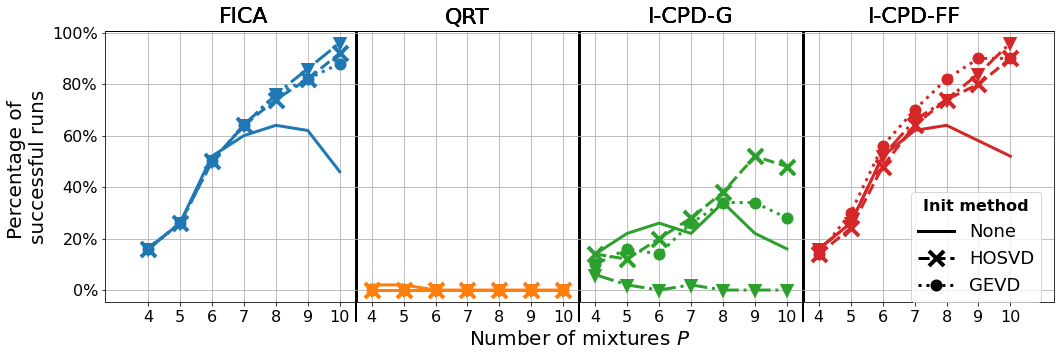

In [66]:
# Plot the failed instances
fig,ax = plt.subplots(figsize=[17,5])

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]
# plist = [0,2,3,3,4,4,1] # OLD, corrected in newer run. I-HOSVD type-U and I-GEVD type-U  correction due to failed instance of LAPACKdls4 which were successfull

FICA = {}; QRT = {}; ffIMP = {}; ffFICA = {}

for i in range(4):  
    count_FICA = np.zeros(len(Prange))
    count_QRT = np.zeros(len(Prange))
    count_ffIMP = np.zeros(len(Prange))
    count_ffFICA = np.zeros(len(Prange))
    for p in range(len(Prange)):
        count_FICA[p] = np.sum([np.copy(fail_FICA[i][0][0])[p,:]==1000])
        count_QRT[p] = np.sum([np.copy(fail_QRT[i][0][0])[p,:]==1000])
        count_ffIMP[p] = np.sum([np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        
        count_ffFICA[p] = np.sum([np.copy(fail_ffFICA[i][0][0])[p,:]==1000]) 

        ## DOLD, correted in newer runs. ONLY UN-COMMENT FOR THE I-HOSVD and I-GEVD TYPE-U METHODS, correction for the misclassified instances due to the LAPACKdls4 error  --OLD
        # if i == 2:
        #     count_ffFICA[p] = np.sum([np.copy(fail_ffFICA[i][0][0])[p,:]==1000]) #+plist[p]
        # else:
        #     count_ffFICA[p] = np.sum([np.copy(fail_ffFICA[i][0][0])[p,:]==1000]) 
       
    
    ax.set_xticks([*range(len(Prange)*4)])
    plt.yticks([0,10,20,30,40,50],labels=['0%','20%','40%','60%','80%','100%'],fontsize=16)
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    FICA[i], = plt.plot(range(len(Prange)),count_FICA,label='FICA',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[0])
    QRT[i], = plt.plot(range(len(Prange),len(Prange)+len(Prange)),count_QRT,label='QRT',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[1])
    ffIMP[i], = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),count_ffIMP,label='I-CPD-G',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[2])
    ffFICA[i], = plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),count_ffFICA,label='I-CPD-FF',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[3])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    ax.set_ylabel('Percentage of \nsuccessful runs',fontsize=20)
    plt.grid('on',which='minor',linewidth=3,color='k')
    plt.grid('on',which='major')

    secaxX1 = ax.secondary_xaxis(location=1)
    secaxX1.set_xticks([3,10,17,24])
    secaxX1.set_xticklabels(['FICA','QRT','I-CPD-G','I-CPD-FF'],fontsize=22)
    secaxX1.tick_params(which='major',length=0)

leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HOSVD','GEVD'],fontsize=18,loc=[0.85,0.0])
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=18,loc=[0.85,0.0])
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2],FICA[3]],labels=['GEVD','I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=18,loc=[0.85,0.0])
title = leg.get_title()
leg.set_title('Init method')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
handles[1].set_color('k')
handles[2].set_color('k')
# handles[3].set_color('k')

20.58514668125755 146.04166666666666 0.1409539287732329
32.158552443698426 136.84782608695653 0.23499498211439673
10.227426871733998 33.0625 0.3093361624721058
28.07724340497518 142.79166666666666 0.19663082629687903
36.85026284106501 133.2826086956522 0.2764821547364199
9.176415270802767 34.291666666666664 0.26759898724090697
1.4275178399462611 149.69565217391303 0.00953613427788673
nan nan nan
19.497989579265244 27.46153846153846 0.710010825015261


c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

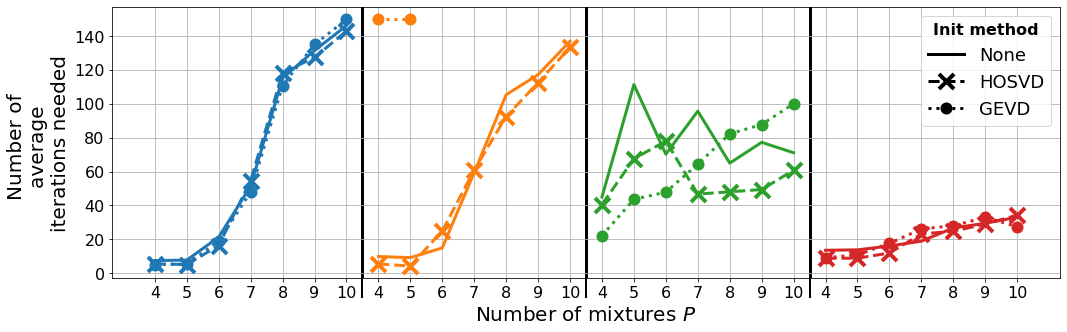

In [20]:
## Plot number of iterations needed
fig,ax = plt.subplots(figsize=[17,5])

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]
# sL = [0.95,0.85,0.72,0.72]
# sL = [1,1,1,1]

FICA = {}; QRT = {}; ffIMP = {}; ffFICA = {}

for i in range(3):

    FICA_niter_succes = np.mean(FICA_niter[i][0][0],axis=1)
    QRT_niter_succes = np.mean(QRT_niter[i][0][0],axis=1)
    ffIMP_niter_succes = np.mean(ffIMP_niter[i][0][0],axis=1)
    ffFICA_niter_succes = np.mean(ffFICA_niter[i][0][0],axis=1)

    FICA_niter_succes_std = np.std(FICA_niter[i][0][0],axis=1)
    QRT_niter_succes_std = np.std(QRT_niter[i][0][0],axis=1)
    ffIMP_niter_succes_std = np.std(ffIMP_niter[i][0][0],axis=1)
    ffFICA_niter_succes_std = np.std(ffFICA_niter[i][0][0],axis=1)

    # Rmove failed instances
    for p in range(len(Prange)):
        FICA_niter_succes[p] = np.mean(np.copy(FICA_niter[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        QRT_niter_succes[p] = np.mean(np.copy(QRT_niter[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        ffIMP_niter_succes[p] = np.mean(np.copy(ffIMP_niter[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        ffFICA_niter_succes[p] = np.mean(np.copy(ffFICA_niter[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

        FICA_niter_succes_std[p] = np.std(np.copy(FICA_niter[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        QRT_niter_succes_std[p] = np.std(np.copy(QRT_niter[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        ffIMP_niter_succes_std[p] = np.std(np.copy(ffIMP_niter[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        ffFICA_niter_succes_std[p] = np.std(np.copy(ffFICA_niter[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

    FICA_diff = FICA_niter_succes-FICA_niter_succes_std
    FICA_diff[FICA_diff<0] = 0
    QRT_diff = QRT_niter_succes-QRT_niter_succes_std
    QRT_diff[QRT_diff<0] = 0

    print(FICA_niter_succes_std[-1],FICA_niter_succes[-1],FICA_niter_succes_std[-1]/FICA_niter_succes[-1])
    print(QRT_niter_succes_std[-1],QRT_niter_succes[-1],QRT_niter_succes_std[-1]/QRT_niter_succes[-1])
    print(ffFICA_niter_succes_std[-1],ffFICA_niter_succes[-1],ffFICA_niter_succes_std[-1]/ffFICA_niter_succes[-1])

    # ax.set_xticks([*range(len(Prange)*3)])
    # plt.yticks(fontsize=16)
    # ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    ax.set_xticks([*range(len(Prange)*4)])
    plt.yticks(fontsize=16)
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    FICA[i], = plt.plot(range(len(Prange)),FICA_niter_succes,label='FICA',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[0])
    # plt.fill_between(range(len(Prange)),FICA_diff,FICA_niter_succes+FICA_niter_succes_std,alpha=.35,color=colors[0])
    QRT[i], = plt.plot(range(len(Prange),len(Prange)+len(Prange)),QRT_niter_succes,label='QRT',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[1])
    # plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),QRT_diff,QRT_niter_succes+QRT_niter_succes_std,alpha=.35,color=colors[1])
    ffIMP[i], = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),0.01*ffIMP_niter_succes,label='I-CPD-G',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[2])
    # plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),ffIMP_niter_succes-ffIMP_niter_succes_std,ffIMP_niter_succes+ffIMP_niter_succes_std,alpha=.15,color=colors[2])
    ffFICA[i], = plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),ffFICA_niter_succes,label='I-CPD-FF',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[3])
    # plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),ffFICA_niter_succes-ffFICA_niter_succes_std,ffFICA_niter_succes+ffFICA_niter_succes_std,alpha=.15,color=colors[3])
    # ffFICA[i], = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),ffFICA_niter_succes,label='I-CPD-FF',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[3])
    # plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),ffFICA_niter_succes-ffFICA_niter_succes_std,ffFICA_niter_succes+ffFICA_niter_succes_std,alpha=.35,color=colors[3])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    # ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),3*len(Prange),len(Prange))])-0.5))
    ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    ax.set_ylabel('Number of \naverage \niterations needed',fontsize=20)
    plt.grid('on',which='minor',linewidth=3,color='k')
    plt.grid('on',which='major')

    # secaxX1 = ax.secondary_xaxis(location=1)
    # secaxX1.set_xticks([3,10,17])
    # secaxX1.set_xticklabels(['FICA','QRT','I-CPD-FF'],fontsize=22)
    secaxX1.set_xticks([3,10,17,24])
    secaxX1.set_xticklabels(['FICA','QRT','I-CPD-G $(\\times 10^{2})$','I-CPD-FF'],fontsize=22)
    secaxX1.set_xticklabels(['FICA','QRT',' ','I-CPD-FF'],fontsize=22)
    secaxX1.tick_params(which='major',length=0)
# plt.yscale('log')
# leg = plt.legend(handles=[FICA[0]],labels=['None'],fontsize=18,loc='upper right')
leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HOSVD','GEVD'],fontsize=18,loc='upper right')
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=18,loc='upper right')
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2],FICA[3]],labels=['GEVD','I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=18,loc='upper right')
title = leg.get_title()
leg.set_title('Init method')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
handles[1].set_color('k')
handles[2].set_color('k')
# handles[3].set_color('k')

c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

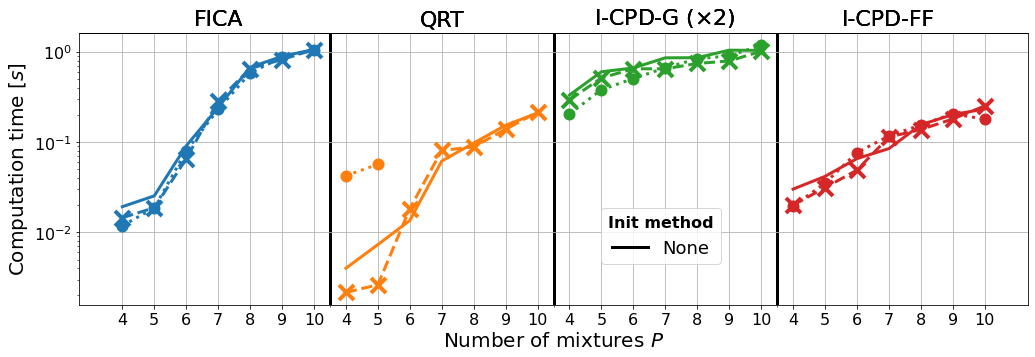

In [21]:
# Time plot over all values for P
fig,ax = plt.subplots(figsize=[17,5])

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]
# sL = [0.95,0.9,0.72,0.72]
# sL = [1,1,1,1]


FICA = {}; QRT = {}; ffIMP = {}; ffFICA = {}

for i in range(3):

    FICA_time_succes = np.mean(FICA_time[i][0][0],axis=1)
    QRT_time_succes = np.mean(QRT_time[i][0][0],axis=1)
    ffIMP_time_succes = np.mean(ffIMP_time[i][0][0],axis=1)
    ffFICA_time_succes = np.mean(ffFICA_time[i][0][0],axis=1)

    FICA_time_succes_std = np.std(FICA_time[i][0][0],axis=1)
    QRT_time_succes_std = np.std(QRT_time[i][0][0],axis=1)
    ffIMP_time_succes_std = np.std(ffIMP_time[i][0][0],axis=1)
    ffFICA_time_succes_std = np.std(ffFICA_time[i][0][0],axis=1)

    for p in range(len(Prange)):
        FICA_time_succes[p] = np.mean(np.copy(FICA_time[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        QRT_time_succes[p] = np.mean(np.copy(QRT_time[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        ffIMP_time_succes[p] = np.mean(np.copy(0.5*ffIMP_time[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        ffFICA_time_succes[p] = np.mean(np.copy(ffFICA_time[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

        FICA_time_succes_std[p] = np.std(np.copy(FICA_time[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        QRT_time_succes_std[p] = np.std(np.copy(QRT_time[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        ffIMP_time_succes_std[p] = np.std(np.copy(0.5*ffIMP_time[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        ffFICA_time_succes_std[p] = np.std(np.copy(ffFICA_time[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

    FICA_diff = FICA_time_succes-FICA_time_succes_std
    FICA_diff[FICA_diff<0] = 0
    QRT_diff = QRT_time_succes-QRT_time_succes_std
    QRT_diff[QRT_diff<0] = 0

    ax.set_xticks([*range(len(Prange)*4)])
    plt.yticks(fontsize=16)
    # plt.ylim([-0.05,1.2])
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    FICA[i], = plt.plot(range(len(Prange)),FICA_time_succes,label='FICA',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[0])
    # plt.fill_between(range(len(Prange)),FICA_diff,FICA_time_succes+FICA_time_succes_std,alpha=.15,color=colors[0])
    QRT[i], = plt.plot(range(len(Prange),len(Prange)+len(Prange)),QRT_time_succes,label='QRT',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[1])
    # plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),QRT_diff,QRT_time_succes+QRT_time_succes_std,alpha=.15,color=colors[1])
    ffIMP[i], = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),ffIMP_time_succes,label='I-CPD-G',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[2])
    # plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),ffIMP_time_succes-ffIMP_time_succes_std,ffIMP_time_succes+ffIMP_time_succes_std,alpha=.15,color=colors[2])
    ffFICA[i], = plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),ffFICA_time_succes,label='I-CPD-FF',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[3])
    # plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),ffFICA_time_succes-ffFICA_time_succes_std,ffFICA_time_succes+ffFICA_time_succes_std,alpha=.15,color=colors[3])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    # ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    plt.ylabel('Computation time $[s]$',fontsize=20)
    plt.grid('on',which='minor',axis='x',linewidth=3,color='k')
    plt.grid('on',which='major')

    secaxX1 = ax.secondary_xaxis(location=1)
    secaxX1.set_xticks([3,10,17,24])
    secaxX1.set_xticklabels(['FICA','QRT','I-CPD-G $(\\times 2)$','I-CPD-FF'],fontsize=22)
    # secaxX1.set_xticklabels(['FICA','QRT',' ','I-CPD-FF'],fontsize=22)
    secaxX1.tick_params(which='major',length=0)

# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HO-W','GEVD'],fontsize=18,loc=[0.845,0.5])
plt.yscale('log')
leg = plt.legend(handles=[FICA[0]],labels=['None'],fontsize=18,loc=[0.55,0.15])
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HOSVD','GEVD'],fontsize=18,loc=[0.55,0.15])
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HOSVD','GEVD'],fontsize=18,loc=[0.3,0.45])
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=18,loc=[0.3,0.45])
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2],FICA[3]],labels=['GEVD','I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=18,loc='upper right')
title = leg.get_title()
leg.set_title('Init method')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
# handles[1].set_color('k')
# handles[2].set_color('k')
# handles[3].set_color('k')

c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

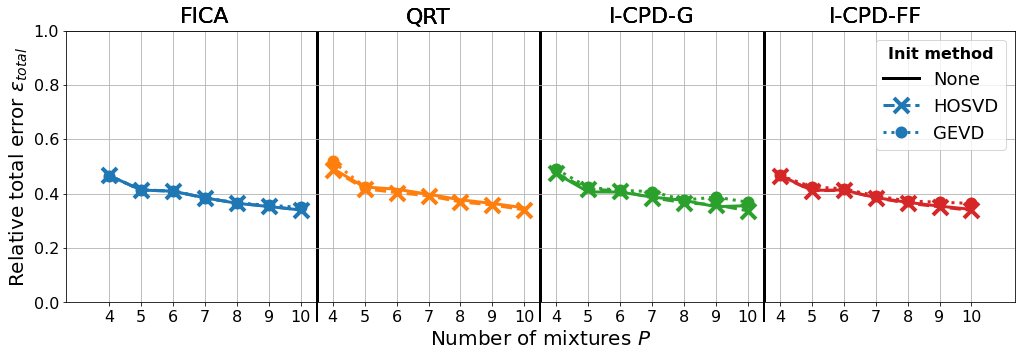

In [22]:
fig,ax = plt.subplots(figsize=[17,5])

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]

FICA = {}; QRT = {}; ffIMP = {}; ffFICA = {}

for i in range(3):

    err_FICA_copy = np.mean(err_FICA[i][0][0],axis=1)
    err_QRT_copy = np.mean(err_QRT[i][0][0],axis=1)
    err_ffIMP_copy = np.mean(err_ffIMP[i][0][0],axis=1)
    err_ffFICA_copy = np.mean(err_ffFICA[i][0][0],axis=1)

    err_FICA_copy_std = np.std(err_FICA[i][0][0],axis=1)
    err_QRT_copy_std = np.std(err_QRT[i][0][0],axis=1)
    err_ffIMP_copy_std = np.std(err_ffIMP[i][0][0],axis=1)
    err_ffFICA_copy_std = np.std(err_ffFICA[i][0][0],axis=1)

    for p in range(len(Prange)):
        err_FICA_copy[p] = np.mean(np.copy(err_FICA[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        err_QRT_copy[p] = np.mean(np.copy(err_QRT[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        err_ffIMP_copy[p] = np.mean(np.copy(err_ffIMP[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        err_ffFICA_copy[p] = np.mean(np.copy(err_ffFICA[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

        err_FICA_copy_std[p] = np.std(np.copy(err_FICA[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        err_QRT_copy_std[p] = np.std(np.copy(err_QRT[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        err_ffIMP_copy_std[p] = np.std(np.copy(err_ffIMP[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        err_ffFICA_copy_std[p] = np.std(np.copy(err_ffFICA[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])


    # Error plot over all values for P
    ax.set_xticks([*range(len(Prange)*4)])
    plt.yticks(fontsize=16)
    # plt.ylim([0.3,0.7])
    # plt.ylim([0.33,0.5])
    plt.ylim([0,1])
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    FICA[i], = plt.plot(range(len(Prange)),err_FICA_copy,label='FICA',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[0])
    # plt.fill_between(range(len(Prange)),err_FICA_copy-err_FICA_copy_std,err_FICA_copy+err_FICA_copy_std,alpha=.15,color=colors[0])
    QRT[i], = plt.plot(range(len(Prange),len(Prange)+len(Prange)),err_QRT_copy,label='QRT',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[1])
    # plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),err_QRT_copy-err_QRT_copy_std,err_QRT_copy+err_QRT_copy_std,alpha=.15,color=colors[1])
    ffIMP[i], = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_ffIMP_copy,label='I-CPD-G',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[2])
    # plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_ffIMP_copy-err_ffIMP_copy_std,err_ffIMP_copy+err_ffIMP_copy_std,alpha=.15,color=colors[2])
    ffFICA[i], = plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_ffFICA_copy,label='I-CPD-FF',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[3])
    # plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_ffFICA_copy-err_ffFICA_copy_std,err_ffFICA_copy+err_ffFICA_copy_std,alpha=.15,color=colors[3])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    plt.ylabel('Relative total error $\\varepsilon_{total}$',fontsize=20)
    plt.grid('on',which='minor',linewidth=3,color='k')
    plt.grid('on',which='major')

    secaxX1 = ax.secondary_xaxis(location=1)
    secaxX1.set_xticks([3,10,17,24])
    secaxX1.set_xticklabels(['FICA','QRT','I-CPD-G','I-CPD-FF'],fontsize=22)
    secaxX1.tick_params(which='major',length=0)

# leg = plt.legend(handles=[FICA[0]],labels=['None'],fontsize=18,loc='upper right')
leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HOSVD','GEVD'],fontsize=18,loc='upper right')
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=18,loc='upper right')
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2],FICA[3]],labels=['GEVD','I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=18,loc=[0.335,0.3])

title = leg.get_title()
leg.set_title('Init method')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
# handles[1].set_color('k')
# handles[2].set_color('k')
# handles[3].set_color('k')

c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

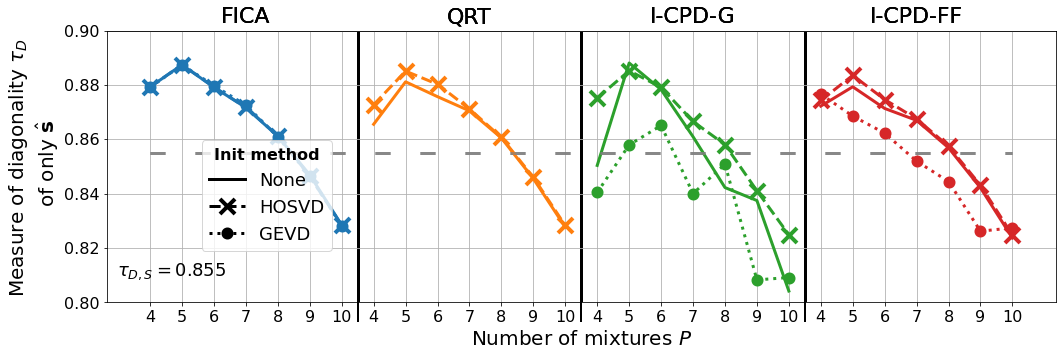

In [24]:
fig,ax = plt.subplots(figsize=[17,5])

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]

FICA = {}; QRT = {}; ffIMP = {}; ffFICA = {}

for i in range(3): 
   
    diag4_FICA_copy = np.mean(diag4_FICA[i][0][0],axis=1)
    diag4_QRT_copy = np.mean(diag4_QRT[i][0][0],axis=1)
    diag4_ffIMP_copy = np.mean(diag4_ffIMP[i][0][0],axis=1)
    diag4_ffFICA_copy = np.mean(diag4_FICA[i][0][0],axis=1)

    diag4_FICA_copy_std = np.std(diag4_FICA[i][0][0],axis=1)
    diag4_QRT_copy_std = np.std(diag4_QRT[i][0][0],axis=1)
    diag4_ffIMP_copy_std = np.std(diag4_ffIMP[i][0][0],axis=1)
    diag4_ffFICA_copy_std = np.std(diag4_ffFICA[i][0][0],axis=1)

    for p in range(len(Prange)):
        diag4_FICA_copy[p] = np.mean(np.copy(diag4_FICA[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        diag4_QRT_copy[p] = np.mean(np.copy(diag4_QRT[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        diag4_ffIMP_copy[p] = np.mean(np.copy(diag4_ffIMP[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        diag4_ffFICA_copy[p] = np.mean(np.copy(diag4_ffFICA[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

        diag4_FICA_copy_std[p] = np.std(np.copy(diag4_FICA[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        diag4_QRT_copy_std[p] = np.std(np.copy(diag4_QRT[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        diag4_ffIMP_copy_std[p] = np.std(np.copy(diag4_ffIMP[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        diag4_ffFICA_copy_std[p] = np.std(np.copy(diag4_ffFICA[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

    # diag4_ffIMP_copy[diag4_ffIMP_copy>1] = 0.865 #+ i/10

    # Measure of digonality of S
    # Szmeanunit = np.copy(S)

    # for p in range(S.shape[0]):
    #     Szmeanunit[p,:] = Szmeanunit[p,:] - np.mean(Szmeanunit[p,:])
    #     Szmeanunit[p,:] = Szmeanunit[p,:]/np.sqrt(mtf.my_inner_prod(Szmeanunit[p,:],Szmeanunit[p,:]))
    # C4tS = mc.cum4tensor(Szmeanunit)[0]
    DIAG4S = 0.855


    # Diag4 plot over all values for P
    ax.set_xticks([*range(len(Prange)*4)])
    line1 = plt.plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='gray',linestyle=(0,(5,10)),linewidth=3,alpha=0.6)

    # plt.ylim([0,1])
    # plt.ylim([0.7,0.9])
    plt.ylim([0.8,0.9])
    ax.set_xticks([*range(len(Prange)*4)])
    plt.yticks(fontsize=16)
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    FICA[i], = plt.plot(range(len(Prange)),diag4_FICA_copy,label='FICA',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[0])
    # plt.fill_between(range(len(Prange)),diag4_FICA_copy-diag4_FICA_copy_std,diag4_FICA_copy+diag4_FICA_copy_std,alpha=.15,color=colors[0])
    QRT[i], = plt.plot(range(len(Prange),len(Prange)+len(Prange)),diag4_QRT_copy,label='QRT',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[1])
    # plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),diag4_QRT_copy-diag4_QRT_copy_std,diag4_QRT_copy+diag4_QRT_copy_std,alpha=.15,color=colors[1])
    ffIMP[i], = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),diag4_ffIMP_copy,label='I-CPD-G',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[2])
    # plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),diag4_ffIMP_copy-diag4_ffIMP_copy_std,diag4_ffIMP_copy+diag4_ffIMP_copy_std,alpha=.15,color=colors[2])
    ffFICA[i], = plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),diag4_ffFICA_copy,label='I-CPD-FF',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[3])
    # plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),diag4_ffFICA_copy-diag4_ffFICA_copy_std,diag4_ffFICA_copy+diag4_ffFICA_copy_std,alpha=.15,color=colors[3])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    # plt.ylabel('Measure of diagonality $\\tau_{D}$',fontsize=20)
    plt.ylabel('Measure of diagonality $\\tau_{D}$ \n of only $\hat{\mathbf{s}}$',fontsize=20)

    plt.grid('on',which='minor',linewidth=3,color='k')
    plt.grid('on',which='major')

    secaxX1 = ax.secondary_xaxis(location=1)
    secaxX1.set_xticks([3,10,17,24])
    secaxX1.set_xticklabels(['FICA','QRT','I-CPD-G','I-CPD-FF'],fontsize=22)
    secaxX1.tick_params(which='major',length=0)

leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HOSVD','GEVD'],fontsize=18,loc=[0.1,0.19])
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=18,loc='lower left')
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2],FICA[3]],labels=['GEVD','I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=18,loc=[0.28,0.4])

title = leg.get_title()
leg.set_title('Init method')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
handles[1].set_color('k')
handles[2].set_color('k')
# handles[3].set_color('k')

plt.gca().add_artist(leg)
# leg2 = plt.legend(handles=line1,labels=['$\\tau_{D,S}=0.855$'],fontsize=18,loc=[-0.05,0.645])
leg2 = plt.legend(handles=line1,labels=['$\\tau_{D,S}=0.855$'],fontsize=18,loc=[-0.05,0.05])
leg2.set_frame_on(False)
handles2 = leg2.legendHandles
handles2[0].set_color('None')


c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

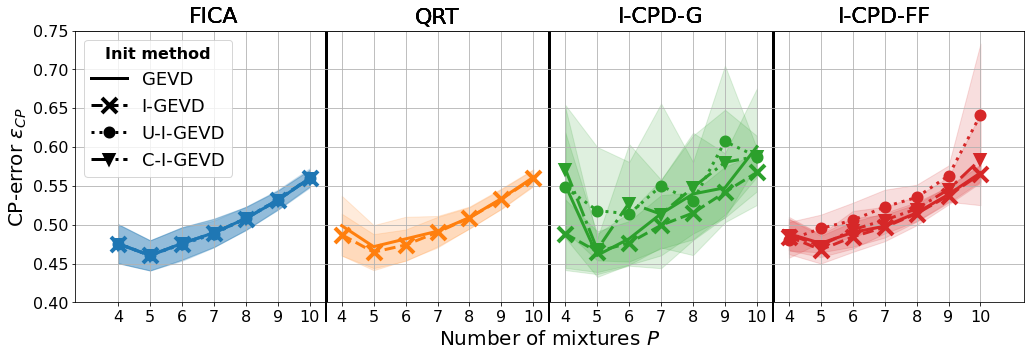

In [25]:
fig,ax = plt.subplots(figsize=[17,5])

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]

FICA = {}; QRT = {}; ffIMP = {}; ffFICA = {}

for i in range(4):
   
    CPD_errorFICA_copy = np.mean(CPD_errorFICA[i][0][0],axis=1)
    CPD_errorQRT_copy = np.mean(CPD_errorQRT[i][0][0],axis=1)
    CPD_errorffIMP_copy = np.mean(CPD_errorffIMP[i][0][0],axis=1)
    CPD_errorffFICA_copy = np.mean(CPD_errorFICA[i][0][0],axis=1)

    CPD_errorFICA_copy_std = np.std(CPD_errorFICA[i][0][0],axis=1)
    CPD_errorQRT_copy_std = np.std(CPD_errorQRT[i][0][0],axis=1)
    CPD_errorffIMP_copy_std = np.std(CPD_errorffIMP[i][0][0],axis=1)
    CPD_errorffFICA_copy_std = np.std(CPD_errorffFICA[i][0][0],axis=1)

    for p in range(len(Prange)):
        CPD_errorFICA_copy[p] = np.mean(np.copy(CPD_errorFICA[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        CPD_errorQRT_copy[p] = np.mean(np.copy(CPD_errorQRT[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        CPD_errorffIMP_copy[p] = np.mean(np.copy(CPD_errorffIMP[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        CPD_errorffFICA_copy[p] = np.mean(np.copy(CPD_errorffFICA[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

        CPD_errorFICA_copy_std[p] = np.std(np.copy(CPD_errorFICA[i][0][0])[p,:][np.copy(fail_FICA[i][0][0])[p,:]==1000])
        CPD_errorQRT_copy_std[p] = np.std(np.copy(CPD_errorQRT[i][0][0])[p,:][np.copy(fail_QRT[i][0][0])[p,:]==1000])
        CPD_errorffIMP_copy_std[p] = np.std(np.copy(CPD_errorffIMP[i][0][0])[p,:][np.copy(fail_ffIMP[i][0][0])[p,:]==1000])
        CPD_errorffFICA_copy_std[p] = np.std(np.copy(CPD_errorffFICA[i][0][0])[p,:][np.copy(fail_ffFICA[i][0][0])[p,:]==1000])

    # # CP error of S with itself
    # lamS = [C4tS[i,i,i,i] for i in range(S.shape[0])]; US = np.eye(S.shape[0])
    # CPD_errorS = mc.CPDerror(np.copy(C4tS),lamS,US,True)


    # CPD error plot over all values for P
    plt.ylim([0.4,0.75])
    ax.set_xticks([*range(len(Prange)*4)])
    plt.yticks(fontsize=16)
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    FICA[i], = plt.plot(range(len(Prange)),CPD_errorFICA_copy,label='FICA',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[0])
    plt.fill_between(range(len(Prange)),CPD_errorFICA_copy-CPD_errorFICA_copy_std,CPD_errorFICA_copy+CPD_errorFICA_copy_std,alpha=.15,color=colors[0])
    QRT[i], = plt.plot(range(len(Prange),len(Prange)+len(Prange)),CPD_errorQRT_copy,label='QRT',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[1])
    plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),CPD_errorQRT_copy-CPD_errorQRT_copy_std,CPD_errorQRT_copy+CPD_errorQRT_copy_std,alpha=.15,color=colors[1])
    ffIMP[i], = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),CPD_errorffIMP_copy,label='I-CPD-G',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[2])
    plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),CPD_errorffIMP_copy-CPD_errorffIMP_copy_std,CPD_errorffIMP_copy+CPD_errorffIMP_copy_std,alpha=.15,color=colors[2])
    ffFICA[i], = plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),CPD_errorffFICA_copy,label='I-CPD-FF',linewidth=3,linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i],color=colors[3])
    plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),CPD_errorffFICA_copy-CPD_errorffFICA_copy_std,CPD_errorffFICA_copy+CPD_errorffFICA_copy_std,alpha=.15,color=colors[3])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    plt.ylabel('CP-error $\\varepsilon_{CP}$',fontsize=20)
    plt.grid('on',which='minor',linewidth=3,color='k')
    plt.grid('on',which='major')

    secaxX1 = ax.secondary_xaxis(location=1)
    secaxX1.set_xticks([3,10,17,24])
    secaxX1.set_xticklabels(['FICA','QRT','I-CPD-G','I-CPD-FF'],fontsize=22)
    secaxX1.tick_params(which='major',length=0)

# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['None','HOSVD','GEVD'],fontsize=18,loc='upper left')
# leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2]],labels=['I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=18,loc='upper left')
leg = plt.legend(handles=[FICA[0],FICA[1],FICA[2],FICA[3]],labels=['GEVD','I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=18,loc='upper left')
title = leg.get_title()
leg.set_title('Init method')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
handles[1].set_color('k')
handles[2].set_color('k')
handles[3].set_color('k')

## noniter

The following lines of code are used to plot the results of the non-iterative algorithms. The code is structured in aa similar way as with the iterative-algorithms.
There is one difference and that is that before being able to plot the metrics all of the previous code boxes have to be ran. These boxed remove the failed instances and reformat the end results such that it can be plotted.

In [39]:
from scipy.io import loadmat
# # Correct mixing model
noniterFULL_dict_init = loadmat('NONiter100_correctFULL_dict.mat')
noniterHALF_dict_init = loadmat('NONiter100_correctHALF_dict.mat')
noniterCORE_dict_init = loadmat('NONiter100_correctCORE_dict.mat')

# # diagonal of subtensor S
# noniterFULL_dict_init = loadmat('NONiter100DIAG_correctFULL_dict.mat')
# noniterHALF_dict_init = loadmat('NONiter100DIAG_correctHALF_dict.mat')
# noniterCORE_dict_init = loadmat('NONiter100DIAG_correctCORE_dict.mat')


fail_HOSVD = {}; fail_IHOSVD= {}; fail_GEVD = {}; fail_IGEVD = {}

fail_HOSVD[0] = noniterFULL_dict_init['fail']['HOSVD']
fail_IHOSVD[0] = noniterFULL_dict_init['fail']['IHOSVD']
fail_GEVD[0]  = noniterFULL_dict_init['fail']['GEVD']
fail_IGEVD[0]  = noniterFULL_dict_init['fail']['IGEVD']

fail_HOSVD[1] = noniterHALF_dict_init['fail']['HOSVD']
fail_IHOSVD[1] = noniterHALF_dict_init['fail']['IHOSVD']
fail_GEVD[1]  = noniterHALF_dict_init['fail']['GEVD']
fail_IGEVD[1]  = noniterHALF_dict_init['fail']['IGEVD']

fail_HOSVD[2] = noniterCORE_dict_init['fail']['HOSVD']
fail_IHOSVD[2] = noniterCORE_dict_init['fail']['IHOSVD']
fail_GEVD[2]  = noniterCORE_dict_init['fail']['GEVD']
fail_IGEVD[2]  = noniterCORE_dict_init['fail']['IGEVD']

HOSVD_time = {}; IHOSVD_time = {}; GEVD_time = {}; IGEVD_time = {}

HOSVD_time[0] = noniterFULL_dict_init['time']['HOSVD']
IHOSVD_time[0] = noniterFULL_dict_init['time']['IHOSVD']
GEVD_time[0]  = noniterFULL_dict_init['time']['GEVD']
IGEVD_time[0]  = noniterFULL_dict_init['time']['IGEVD']

HOSVD_time[1] = noniterHALF_dict_init['time']['HOSVD']
IHOSVD_time[1] = noniterHALF_dict_init['time']['IHOSVD']
GEVD_time[1]  = noniterHALF_dict_init['time']['GEVD']
IGEVD_time[1]  = noniterHALF_dict_init['time']['IGEVD']

HOSVD_time[2] = noniterCORE_dict_init['time']['HOSVD']
IHOSVD_time[2] = noniterCORE_dict_init['time']['IHOSVD']
GEVD_time[2]  = noniterCORE_dict_init['time']['GEVD']
IGEVD_time[2]  = noniterCORE_dict_init['time']['IGEVD']

err_HOSVD = {}; err_IHOSVD = {}; err_GEVD = {}; err_IGEVD = {}

err_HOSVD[0] = noniterFULL_dict_init['error']['HOSVD']
err_IHOSVD[0] = noniterFULL_dict_init['error']['IHOSVD']
err_GEVD[0]  = noniterFULL_dict_init['error']['GEVD']
err_IGEVD[0]  = noniterFULL_dict_init['error']['IGEVD']

err_HOSVD[1] = noniterHALF_dict_init['error']['HOSVD']
err_IHOSVD[1] = noniterHALF_dict_init['error']['IHOSVD']
err_GEVD[1]  = noniterHALF_dict_init['error']['GEVD']
err_IGEVD[1]  = noniterHALF_dict_init['error']['IGEVD']

err_HOSVD[2] = noniterCORE_dict_init['error']['HOSVD']
err_IHOSVD[2] = noniterCORE_dict_init['error']['IHOSVD']
err_GEVD[2]  = noniterCORE_dict_init['error']['GEVD']
err_IGEVD[2]  = noniterCORE_dict_init['error']['IGEVD']

diag4_HOSVD = {}; diag4_IHOSVD = {}; diag4_GEVD ={}; diag4_IGEVD = {}

diag4_HOSVD[0] = noniterFULL_dict_init['diag4']['HOSVD']
diag4_IHOSVD[0] = noniterFULL_dict_init['diag4']['IHOSVD']
diag4_GEVD[0]  = noniterFULL_dict_init['diag4']['GEVD']
diag4_IGEVD[0]  = noniterFULL_dict_init['diag4']['IGEVD']

diag4_HOSVD[1] = noniterHALF_dict_init['diag4']['HOSVD']
diag4_IHOSVD[1] = noniterHALF_dict_init['diag4']['IHOSVD']
diag4_GEVD[1]  = noniterHALF_dict_init['diag4']['GEVD']
diag4_IGEVD[1]  = noniterHALF_dict_init['diag4']['IGEVD']

diag4_HOSVD[2] = noniterCORE_dict_init['diag4']['HOSVD']
diag4_IHOSVD[2] = noniterCORE_dict_init['diag4']['IHOSVD']
diag4_GEVD[2]  = noniterCORE_dict_init['diag4']['GEVD']
diag4_IGEVD[2]  = noniterCORE_dict_init['diag4']['IGEVD']


# noniterDIAG_dict_init = loadmat('NONiterDIAG_dict.mat')
# diag4_HOSVD = noniterDIAG_dict_init['diag4']['HOSVD']
# diag4_IHOSVD = noniterDIAG_dict_init['diag4']['IHOSVD']
# diag4_GEVD  = noniterDIAG_dict_init['diag4']['GEVD']
# diag4_IGEVD  = noniterDIAG_dict_init['diag4']['IGEVD']

CPD_errorHOSVD = {}; CPD_errorIHOSVD = {}; CPD_errorGEVD = {}; CPD_errorIGEVD = {}

CPD_errorHOSVD[0] = noniterFULL_dict_init['CPD_error']['HOSVD']
CPD_errorIHOSVD[0] = noniterFULL_dict_init['CPD_error']['IHOSVD']
CPD_errorGEVD[0]  = noniterFULL_dict_init['CPD_error']['GEVD']
CPD_errorIGEVD[0]  = noniterFULL_dict_init['CPD_error']['IGEVD']

CPD_errorHOSVD[1] = noniterHALF_dict_init['CPD_error']['HOSVD']
CPD_errorIHOSVD[1] = noniterHALF_dict_init['CPD_error']['IHOSVD']
CPD_errorGEVD[1]  = noniterHALF_dict_init['CPD_error']['GEVD']
CPD_errorIGEVD[1]  = noniterHALF_dict_init['CPD_error']['IGEVD']

CPD_errorHOSVD[2] = noniterCORE_dict_init['CPD_error']['HOSVD']
CPD_errorIHOSVD[2] = noniterCORE_dict_init['CPD_error']['IHOSVD']
CPD_errorGEVD[2]  = noniterCORE_dict_init['CPD_error']['GEVD']
CPD_errorIGEVD[2]  = noniterCORE_dict_init['CPD_error']['IGEVD']


C4t_time = noniterFULL_dict_init['C4t-time']


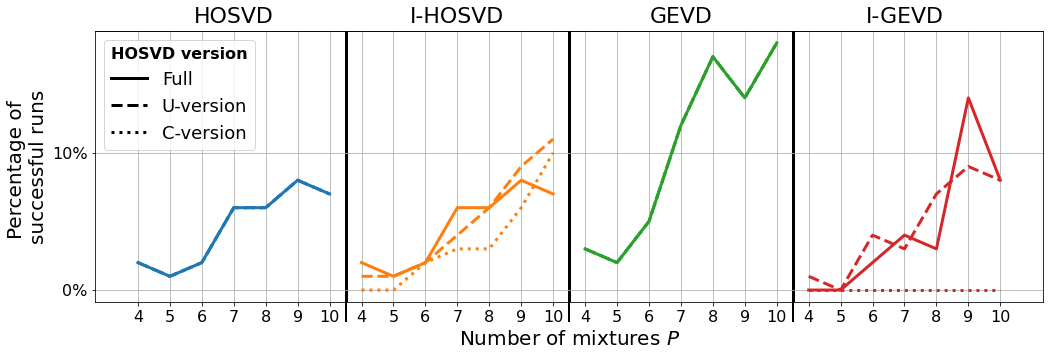

In [40]:
# Plot the failed instances in percentage
fig,ax = plt.subplots(figsize=[17,5])

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]

p1 = {}

for i in range(3):

    count_HOSVD = np.zeros(len(Prange))
    count_IHOSVD = np.zeros(len(Prange))
    count_GEVD = np.zeros(len(Prange))
    count_IGEVD = np.zeros(len(Prange))
    for p in range(len(Prange)):
        count_HOSVD[p] = np.sum([np.copy(fail_HOSVD[i][0][0])[p,:]==1000])
        count_IHOSVD[p] = np.sum([np.copy(fail_IHOSVD[i][0][0])[p,:]==1000])
        count_GEVD[p] = np.sum([np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        count_IGEVD[p] = np.sum([np.copy(fail_IGEVD[i][0][0])[p,:]==1000])

    ax.set_xticks([*range(len(Prange)*4)])
    plt.yticks([0,10,20,30,40],labels=['0%','10%','20%','30%','40%'],fontsize=16)
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    p1[i], = plt.plot(range(len(Prange)),count_HOSVD,label='HOSVD',linewidth=3,color=colors[0],linestyle=linestyleL[i])
    plt.plot(range(len(Prange),len(Prange)+len(Prange)),count_IHOSVD,label='I-HOSVD',linewidth=3,color=colors[1],linestyle=linestyleL[i])
    plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),count_GEVD,label='GEVD',linewidth=3,color=colors[2],linestyle=linestyleL[i])
    plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),count_IGEVD,label='I-GEVD',linewidth=3,color=colors[3],linestyle=linestyleL[i])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    ax.set_ylabel('Percentage of \nsuccessful runs',fontsize=20)
    plt.grid('on',which='minor',linewidth=3,color='k')
    plt.grid('on',which='major')

leg = plt.legend(handles=[p1[0],p1[1],p1[2]],labels=['Full','U-version','C-version'],fontsize=18,loc='upper left')
title = leg.get_title()
leg.set_title('HOSVD version')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
handles[1].set_color('k')
handles[2].set_color('k')


secaxX1 = ax.secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['HOSVD','I-HOSVD','GEVD','I-GEVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

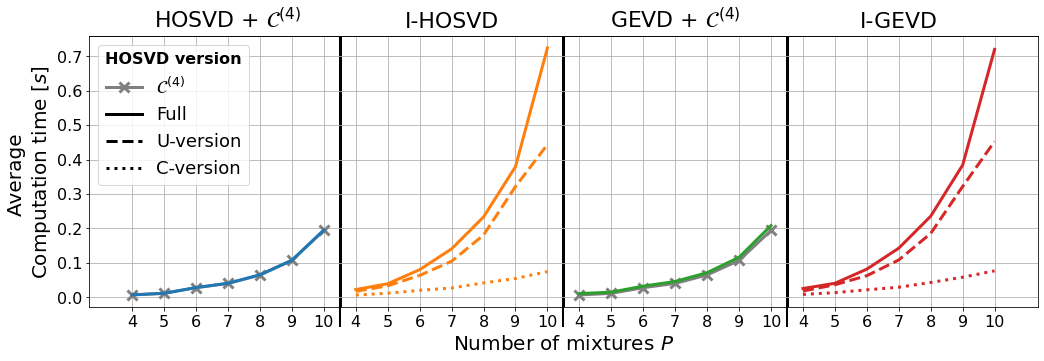

In [41]:
# Time plot over all values for P
fig,ax = plt.subplots(figsize=[17,5])

p1 = {}

for i in range(3):

    plt.yticks(fontsize=16)
    ax.set_xticks([*range(len(Prange)*4)])
    ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
    
    if i == 0:
        pc, = plt.plot(range(len(Prange)),np.mean(C4t_time,axis=1),label='HOSVD + $\mathcal{C}^{(4)}$',linewidth=3,linestyle=linestyleL[i],color='gray',marker='x',markeredgewidth=3,markersize=10)
        plt.plot(range(len(Prange)),np.mean(C4t_time+HOSVD_time[i][0][0],axis=1),label='HOSVD + $\mathcal{C}^{(4)}$',linewidth=3,linestyle=linestyleL[i],color=colors[0])
        
        # plt.fill_between(range(len(Prange)),np.mean(C4t_time+HOSVD_time[i][0][0],axis=1)-np.std(C4t_time+HOSVD_time[i][0][0],axis=1),np.mean(C4t_time+HOSVD_time[i][0][0],axis=1)+np.std(C4t_time+HOSVD_time[i][0][0],axis=1),alpha=.3,color=colors[0])
    plt.plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(IHOSVD_time[i][0][0],axis=1),label='I-HOSVD',linewidth=3,linestyle=linestyleL[i],color=colors[1])
    # plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(IHOSVD_time[i][0][0],axis=1)-np.std(IHOSVD_time[i][0][0],axis=1),np.mean(IHOSVD_time[i][0][0],axis=1)+np.std(IHOSVD_time[i][0][0],axis=1),alpha=.3,color=colors[1])
    if i == 0:
        pc, = plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(C4t_time,axis=1),label='HOSVD + $\mathcal{C}^{(4)}$',linewidth=3,linestyle=linestyleL[i],color='gray',marker='x',markeredgewidth=3,markersize=10)
        plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(C4t_time+GEVD_time[i][0][0],axis=1),label='GEVD + $\mathcal{C}^{(4)}$',linewidth=3,linestyle=linestyleL[i],color=colors[2])
        # plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(C4t_time+GEVD_time[i][0][0],axis=1)-np.std(C4t_time+GEVD_time[i][0][0],axis=1),np.mean(C4t_time+GEVD_time[i][0][0],axis=1)+np.std(C4t_time+GEVD_time[i][0][0],axis=1),alpha=.3,color=colors[2])
    p1[i], = plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(IGEVD_time[i][0][0],axis=1),label='I-GEVD',linewidth=3,linestyle=linestyleL[i],color=colors[3])
    # plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(IGEVD_time[i][0][0],axis=1)-np.std(IGEVD_time[i][0][0],axis=1),np.mean(IGEVD_time[i][0][0],axis=1)+np.std(IGEVD_time[i][0][0],axis=1),alpha=.3,color=colors[3])
    ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
    ax.tick_params(which='minor',length=20,width=2)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    plt.ylabel('Average \nComputation time $[s]$',fontsize=20)
    plt.grid('on',which='minor',linewidth=3,color='k')
    plt.grid('on',which='major')
    # plt.legend(fontsize=20)

leg = plt.legend(handles=[pc,p1[0],p1[1],p1[2]],labels=['$\mathcal{C}^{(4)}$','Full','U-version','C-version'],fontsize=18,loc='upper left')
title = leg.get_title()
leg.set_title('HOSVD version')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[1].set_color('k')
handles[2].set_color('k')
handles[3].set_color('k')

secaxX1 = ax.secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['HOSVD + $\mathcal{C}^{(4)}$','I-HOSVD','GEVD + $\mathcal{C}^{(4)}$','I-GEVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

In [42]:
## RUN THIS CODE TOGETHER WITH THE NEXT ONE TO PLOT THE RESULTS IN THE CODE WINDOW AFTE THAT
p1 = {}

diag4_IHOSVD_copy = {}; diag4_IGEVD_copy = {}; diag4_GEVD_copy = {}

for i in range(3):

    # Diagonality plot of succesfull runs
    diag4_IHOSVD_copy[i] = np.copy(diag4_IHOSVD[i][0][0])
    diag4_IGEVD_copy[i] = np.copy(diag4_IGEVD[i][0][0])
    diag4_GEVD_copy[i] = np.copy(diag4_GEVD[i][0][0])
    for p in range(len(Prange)):
        L_diag4_IHOSVD = list(diag4_IHOSVD_copy[i][p,:])
        L_diag4_IHOSVDNEW = [i for i in L_diag4_IHOSVD if i <= 1]
        diag4_IHOSVD_copy[i][p,:][diag4_IHOSVD_copy[i][p,:] > 1000] = np.mean(L_diag4_IHOSVDNEW)

        L_diag4_GEVD = list(diag4_GEVD_copy[i][p,:])
        L_diag4_GEVDNEW = [i for i in L_diag4_GEVD if i <= 1]
        diag4_GEVD_copy[i][p,:][diag4_GEVD_copy[i][p,:] > 1] = np.mean(L_diag4_GEVDNEW)

        L_diag4_IGEVD = list(diag4_IGEVD_copy[i][p,:])
        L_diag4_IGEVDNEW = [i for i in L_diag4_IGEVD if i <= 1]
        diag4_IGEVD_copy[i][p,:][diag4_IGEVD_copy[i][p,:] > 1] = np.mean(L_diag4_IGEVDNEW)


In [43]:
err_HOSVD_copy = {}; err_IHOSVD_copy = {}; err_GEVD_copy = {}; err_IGEVD_copy = {}
err_HOSVD_copy_std = {}; err_IHOSVD_copy_std = {}; err_GEVD_copy_std = {}; err_IGEVD_copy_std = {}

for i in range(3):
    err_HOSVD_copy[i] = np.mean(diag4_HOSVD[i][0][0],axis=1)
    err_IHOSVD_copy[i] = np.mean(diag4_IHOSVD[i][0][0],axis=1)
    err_GEVD_copy[i] = np.mean(diag4_GEVD[i][0][0],axis=1)
    err_IGEVD_copy[i] = np.mean(diag4_IGEVD[i][0][0],axis=1)

    err_HOSVD_copy_std[i] = np.std(diag4_HOSVD[i][0][0],axis=1)
    err_IHOSVD_copy_std[i] = np.std(diag4_IHOSVD[i][0][0],axis=1)
    err_GEVD_copy_std[i] = np.std(diag4_GEVD[i][0][0],axis=1)
    err_IGEVD_copy_std[i] = np.std(diag4_IGEVD[i][0][0],axis=1)

    for p in range(len(Prange)):
        err_HOSVD_copy[i][p] = np.mean(np.copy(diag4_HOSVD[i][0][0])[p,:][np.copy(fail_HOSVD[i][0][0])[p,:]==1000])
        err_IHOSVD_copy[i][p] = np.mean(np.copy(diag4_IHOSVD[i][0][0])[p,:][np.copy(fail_IHOSVD[i][0][0])[p,:]==1000])
        err_GEVD_copy[i][p] = np.mean(np.copy(diag4_GEVD[i][0][0])[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy[i][p] = np.mean(np.copy(diag4_IGEVD[i][0][0])[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])

        err_HOSVD_copy_std[i][p] = np.std(np.copy(diag4_HOSVD[i][0][0])[p,:][np.copy(fail_HOSVD[i][0][0])[p,:]==1000])
        err_IHOSVD_copy_std[i][p] = np.std(np.copy(diag4_IHOSVD[i][0][0])[p,:][np.copy(fail_IHOSVD[i][0][0])[p,:]==1000])
        err_GEVD_copy_std[i][p] = np.std(np.copy(diag4_GEVD[i][0][0])[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy_std[i][p] = np.std(np.copy(diag4_IGEVD[i][0][0])[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])


c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

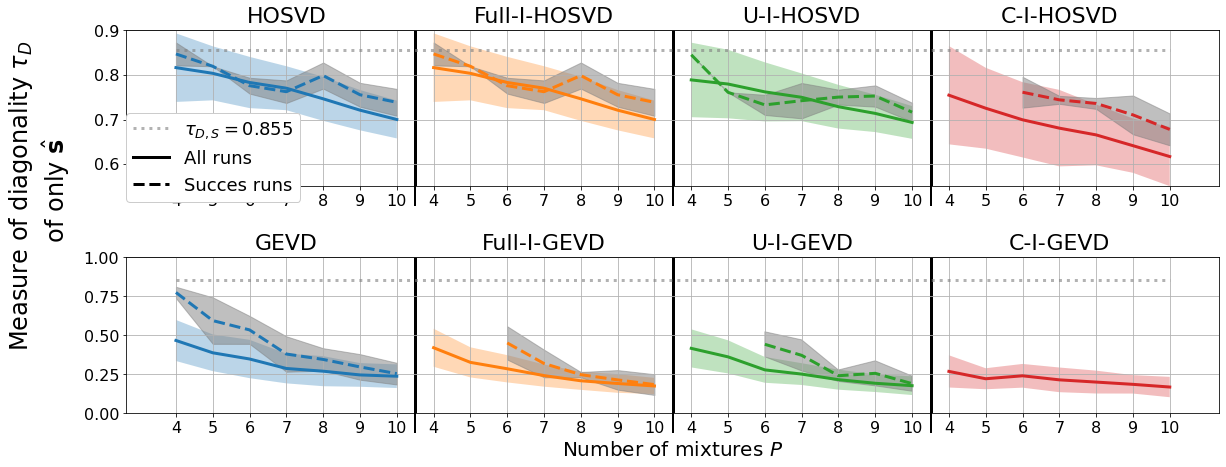

In [44]:
i = 0

# COmbine the all and success plots - FIRST RUN PREVIOUS CODE BOXES
# diag4 plot over all values for P
fig,ax = plt.subplots(2,1,figsize=[17,7])
fig.tight_layout(pad=5)
ax[0].set_ylim([0.55,0.9])
ax[0].set_xticks([*range(len(Prange)*4)])
ax[1].set_xticks([*range(len(Prange)*4)])
ax[0].tick_params(which='major',axis='y',labelsize=16)
ax[1].tick_params(which='major',axis='y',labelsize=16)
ax[0].set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
ax[0].plot(range(len(Prange)),np.mean(diag4_HOSVD[i][0][0],axis=1),label='HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)),np.mean(diag4_HOSVD[i][0][0],axis=1)-np.std(diag4_HOSVD[i][0][0],axis=1),np.mean(diag4_HOSVD[i][0][0],axis=1)+np.std(diag4_HOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)),err_HOSVD_copy[i],label='HOSVD',linewidth=3,color=colors[0],linestyle='dashed')
ax[0].fill_between(range(len(Prange)),err_HOSVD_copy[i]-err_HOSVD_copy_std[i],err_HOSVD_copy[i]+err_HOSVD_copy_std[i],alpha=.5,color='gray')

ax[0].plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD[i][0][0],axis=1)-np.std(diag4_IHOSVD[i][0][0],axis=1),np.mean(diag4_IHOSVD[i][0][0],axis=1)+np.std(diag4_IHOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange),len(Prange)+len(Prange)),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange),len(Prange)+len(Prange)),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.5,color='gray')
i = 1
ax[0].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IHOSVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IHOSVD[i][0][0],axis=1)-np.std(diag4_IHOSVD[i][0][0],axis=1),np.mean(diag4_IHOSVD[i][0][0],axis=1)+np.std(diag4_IHOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.5,color='gray')
i = 2
ax[0].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IHOSVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IHOSVD[i][0][0],axis=1)-np.std(diag4_IHOSVD[i][0][0],axis=1),np.mean(diag4_IHOSVD[i][0][0],axis=1)+np.std(diag4_IHOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.5,color='gray')

i = 0
diag4_IGEVD[i][0][0][diag4_IGEVD[i][0][0]>1] = np.mean(diag4_IGEVD[i][0][0][diag4_IGEVD[i][0][0]<1])
ax[1].set_ylim([0,1])
ax[1].set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
ax[1].plot(range(len(Prange)),np.mean(diag4_GEVD[i][0][0],axis=1),label='HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange)),np.mean(diag4_GEVD[i][0][0],axis=1)-np.std(diag4_GEVD[i][0][0],axis=1),np.mean(diag4_GEVD[i][0][0],axis=1)+np.std(diag4_GEVD[i][0][0],axis=1),alpha=.3)
ax[1].plot(range(len(Prange)),err_GEVD_copy[i],label='HOSVD',linewidth=3,color=colors[0],linestyle='dashed')
ax[1].fill_between(range(len(Prange)),err_GEVD_copy[i]-err_GEVD_copy_std[i],err_GEVD_copy[i]+err_GEVD_copy_std[i],alpha=.5,color='gray')

p1, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD[i][0][0],axis=1)-np.std(diag4_IGEVD[i][0][0],axis=1),np.mean(diag4_IGEVD[i][0][0],axis=1)+np.std(diag4_IGEVD[i][0][0],axis=1),alpha=.3)
p1b, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy[i]-err_IGEVD_copy_std[i],err_IGEVD_copy[i]+err_IGEVD_copy_std[i],alpha=.5,color='gray')
i = 1
diag4_IGEVD[i][0][0][diag4_IGEVD[i][0][0]>1] = np.mean(diag4_IGEVD[i][0][0][diag4_IGEVD[i][0][0]<1])
ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD[i][0][0],axis=1)-np.std(diag4_IGEVD[i][0][0],axis=1),np.mean(diag4_IGEVD[i][0][0],axis=1)+np.std(diag4_IGEVD[i][0][0],axis=1),alpha=.3)
ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy[i]-err_IGEVD_copy_std[i],err_IGEVD_copy[i]+err_IGEVD_copy_std[i],alpha=.5,color='gray')
i = 2
ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IGEVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IGEVD[i][0][0],axis=1)-np.std(diag4_IGEVD[i][0][0],axis=1),np.mean(diag4_IGEVD[i][0][0],axis=1)+np.std(diag4_IGEVD[i][0][0],axis=1),alpha=.3)
ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy[i]-err_IGEVD_copy_std[i],err_IGEVD_copy[i]+err_IGEVD_copy_std[i],alpha=.5,color='gray')


ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax[0].tick_params(which='minor',length=20,width=2)

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax[1].tick_params(which='minor',length=20,width=2)


plt.xlabel('Number of mixtures $P$',fontsize=20)
# ax[0].set_ylabel('Measure of diagonality $\\tau_{D}$',fontsize=24)
ax[0].set_ylabel('Measure of diagonality $\\tau_{D}$ \n of only $\hat{\mathbf{s}}$',fontsize=24)
ax[0].yaxis.set_label_coords(-0.05,-0.05)
# plt.ylabel('Measure of diagonality $\\tau_{D}$ \n of only $\hat{\mathbf{s}}$',fontsize=20)

ax[0].grid('on',which='minor',linewidth=3,color='k')
ax[0].grid('on',which='major')
ax[1].grid('on',which='minor',linewidth=3,color='k')
ax[1].grid('on',which='major')

secaxX1 = ax[0].secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['HOSVD','Full-I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

secaxX1 = ax[1].secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['GEVD','Full-I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

ax[0].plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='gray',linestyle='dotted',linewidth=3,alpha=0.6)
line1, = plt.plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='gray',linestyle='dotted',linewidth=3,alpha=0.6)

leg2 = ax[0].legend(handles=[line1,p1,p1b],labels=['$\\tau_{D,S}=0.855$','All runs','Succes runs'],fontsize=18,loc=[0,-0.1])
leg2.get_frame().set_alpha(1)
handles2 = leg2.legendHandles
handles2[1].set_color('k')
handles2[2].set_color('k')


In [45]:
# Error plot of succesfull runs
diag4_HOSVD_copy = {}
diag4_IHOSVD_copy = {}
diag4_IGEVD_copy = {}
diag4_GEVD_copy = {}

for i in range(3):
    diag4_HOSVD_copy[i] = np.copy(err_HOSVD[i][0][0])
    diag4_IHOSVD_copy[i] = np.copy(err_IHOSVD[i][0][0])
    diag4_IGEVD_copy[i] = np.copy(err_IGEVD[i][0][0])
    diag4_GEVD_copy[i] = np.copy(err_GEVD[i][0][0])
    for p in range(len(Prange)):
        L_diag4_HOSVD = list(diag4_HOSVD_copy[i][p,:])
        L_diag4_HOSVDNEW = [i for i in L_diag4_HOSVD if i <= 1]
        diag4_HOSVD_copy[i][p,:][diag4_HOSVD_copy[i][p,:] > 1000] = np.mean(L_diag4_HOSVDNEW)

        L_diag4_IHOSVD = list(diag4_IHOSVD_copy[i][p,:])
        L_diag4_IHOSVDNEW = [i for i in L_diag4_IHOSVD if i <= 1]
        diag4_IHOSVD_copy[i][p,:][diag4_IHOSVD_copy[i][p,:] > 1000] = np.mean(L_diag4_IHOSVDNEW)

        L_diag4_GEVD = list(diag4_GEVD_copy[i][p,:])
        L_diag4_GEVDNEW = [i for i in L_diag4_GEVD if i <= 1]
        diag4_GEVD_copy[i][p,:][diag4_GEVD_copy[i][p,:] > 1] = np.mean(L_diag4_GEVDNEW)

        L_diag4_IGEVD = list(diag4_IGEVD_copy[i][p,:])
        L_diag4_IGEVDNEW = [i for i in L_diag4_IGEVD if i <= 1]
        diag4_IGEVD_copy[i][p,:][diag4_IGEVD_copy[i][p,:] > 1] = np.mean(L_diag4_IGEVDNEW)



In [46]:
for i in range(3):

    err_HOSVD_copy[i] = np.mean(err_HOSVD[i][0][0],axis=1)
    err_IHOSVD_copy[i] = np.mean(err_IHOSVD[i][0][0],axis=1)
    err_GEVD_copy[i] = np.mean(err_GEVD[i][0][0],axis=1)
    err_IGEVD_copy[i] = np.mean(err_IGEVD[i][0][0],axis=1)

    err_HOSVD_copy_std[i] = np.std(err_HOSVD[i][0][0],axis=1)
    err_IHOSVD_copy_std[i] = np.std(err_IHOSVD[i][0][0],axis=1)
    err_GEVD_copy_std[i] = np.std(err_GEVD[i][0][0],axis=1)
    err_IGEVD_copy_std[i] = np.std(err_IGEVD[i][0][0],axis=1)

    for p in range(len(Prange)):
        err_HOSVD_copy[i][p] = np.mean(np.copy(err_HOSVD[i][0][0])[p,:][np.copy(fail_HOSVD[i][0][0])[p,:]==1000])
        err_IHOSVD_copy[i][p] = np.mean(np.copy(err_IHOSVD[i][0][0])[p,:][np.copy(fail_IHOSVD[i][0][0])[p,:]==1000])
        err_GEVD_copy[i][p] = np.mean(np.copy(err_GEVD[i][0][0])[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy[i][p] = np.mean(np.copy(err_IGEVD[i][0][0])[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])

        err_HOSVD_copy_std[i][p] = np.std(np.copy(err_HOSVD[i][0][0])[p,:][np.copy(fail_HOSVD[i][0][0])[p,:]==1000])
        err_IHOSVD_copy_std[i][p] = np.std(np.copy(err_IHOSVD[i][0][0])[p,:][np.copy(fail_IHOSVD[i][0][0])[p,:]==1000])
        err_GEVD_copy_std[i][p] = np.std(np.copy(err_GEVD[i][0][0])[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy_std[i][p] = np.std(np.copy(err_IGEVD[i][0][0])[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])

c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

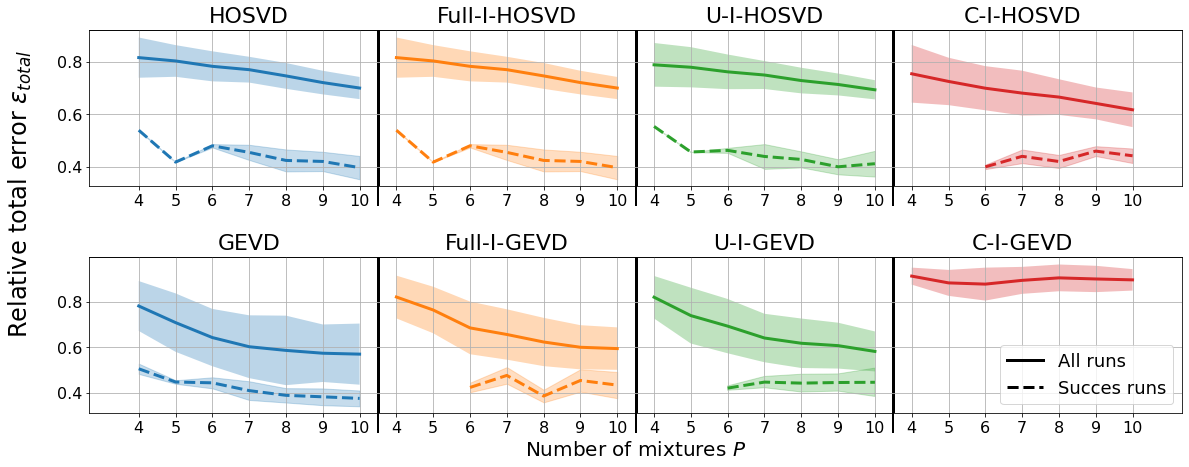

In [35]:
i = 0

# COmbine the all and success plots - FIRST RUN PREVIOUS CODE BOXES
# diag4 plot over all values for P
fig,ax = plt.subplots(2,1,figsize=[17,7])
fig.tight_layout(pad=5)
# ax[0].set_ylim([0.55,1])
ax[0].set_xticks([*range(len(Prange)*4)])
ax[1].set_xticks([*range(len(Prange)*4)])
ax[0].tick_params(which='major',axis='y',labelsize=16)
ax[1].tick_params(which='major',axis='y',labelsize=16)
ax[0].set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
ax[0].plot(range(len(Prange)),np.mean(diag4_HOSVD[i][0][0],axis=1),label='HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)),np.mean(diag4_HOSVD[i][0][0],axis=1)-np.std(diag4_HOSVD[i][0][0],axis=1),np.mean(diag4_HOSVD[i][0][0],axis=1)+np.std(diag4_HOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)),err_HOSVD_copy[i],label='HOSVD',linewidth=3,color=colors[0],linestyle='dashed')
ax[0].fill_between(range(len(Prange)),err_HOSVD_copy[i]-err_HOSVD_copy_std[i],err_HOSVD_copy[i]+err_HOSVD_copy_std[i],alpha=.25,color=colors[0])

ax[0].plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD[i][0][0],axis=1)-np.std(diag4_IHOSVD[i][0][0],axis=1),np.mean(diag4_IHOSVD[i][0][0],axis=1)+np.std(diag4_IHOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange),len(Prange)+len(Prange)),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange),len(Prange)+len(Prange)),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.25,color=colors[i+1])
i = 1
ax[0].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IHOSVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IHOSVD[i][0][0],axis=1)-np.std(diag4_IHOSVD[i][0][0],axis=1),np.mean(diag4_IHOSVD[i][0][0],axis=1)+np.std(diag4_IHOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.25,color=colors[i+1])
i = 2
ax[0].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IHOSVD[i][0][0],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IHOSVD[i][0][0],axis=1)-np.std(diag4_IHOSVD[i][0][0],axis=1),np.mean(diag4_IHOSVD[i][0][0],axis=1)+np.std(diag4_IHOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.25,color=colors[i+1])

i = 0
# ax[1].set_ylim([0,1])
ax[1].set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
ax[1].plot(range(len(Prange)),np.mean(diag4_GEVD_copy[i],axis=1),label='HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange)),np.mean(diag4_GEVD_copy[i],axis=1)-np.std(diag4_GEVD_copy[i],axis=1),np.mean(diag4_GEVD_copy[i],axis=1)+np.std(diag4_GEVD_copy[i],axis=1),alpha=.3)
ax[1].plot(range(len(Prange)),err_GEVD_copy[i],label='HOSVD',linewidth=3,color=colors[0],linestyle='dashed')
ax[1].fill_between(range(len(Prange)),err_GEVD_copy[i]-err_GEVD_copy_std[i],err_GEVD_copy[i]+err_GEVD_copy_std[i],alpha=.25,color=colors[0])

p1, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD_copy[i],axis=1),label='I-HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD_copy[i],axis=1)-np.std(diag4_IGEVD_copy[i],axis=1),np.mean(diag4_IGEVD_copy[i],axis=1)+np.std(diag4_IGEVD_copy[i],axis=1),alpha=.3)
p1b, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy[i]-err_IGEVD_copy_std[i],err_IGEVD_copy[i]+err_IGEVD_copy_std[i],alpha=.25,color=colors[i+1])
i = 1
ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD_copy[i],axis=1),label='I-HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD_copy[i],axis=1)-np.std(diag4_IGEVD_copy[i],axis=1),np.mean(diag4_IGEVD_copy[i],axis=1)+np.std(diag4_IGEVD_copy[i],axis=1),alpha=.3)
ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy[i]-err_IGEVD_copy_std[i],err_IGEVD_copy[i]+err_IGEVD_copy_std[i],alpha=.25,color=colors[i+1])
i = 2
ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IGEVD_copy[i],axis=1),label='I-HOSVD',linewidth=3)
ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IGEVD_copy[i],axis=1)-np.std(diag4_IGEVD_copy[i],axis=1),np.mean(diag4_IGEVD_copy[i],axis=1)+np.std(diag4_IGEVD_copy[i],axis=1),alpha=.3)
ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy[i]-err_IGEVD_copy_std[i],err_IGEVD_copy[i]+err_IGEVD_copy_std[i],alpha=.25,color=colors[i+1])


ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax[0].tick_params(which='minor',length=20,width=2)

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax[1].tick_params(which='minor',length=20,width=2)


plt.xlabel('Number of mixtures $P$',fontsize=20)
ax[0].set_ylabel('Relative total error $\\varepsilon_{total}$',fontsize=24)
ax[0].yaxis.set_label_coords(-0.05,-0.05)
# plt.ylabel('Measure of diagonality $\\tau_{D}$ \n of only $\hat{\mathbf{s}}$',fontsize=20)

ax[0].grid('on',which='minor',linewidth=3,color='k')
ax[0].grid('on',which='major')
ax[1].grid('on',which='minor',linewidth=3,color='k')
ax[1].grid('on',which='major')

secaxX1 = ax[0].secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['HOSVD','Full-I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

secaxX1 = ax[1].secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['GEVD','Full-I-GEVD','U-I-GEVD','C-I-GEVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

# ax[0].plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='gray',linestyle='dotted',linewidth=3,alpha=0.6)
# line1, = plt.plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='gray',linestyle='dotted',linewidth=3,alpha=0.6)

leg2 = ax[1].legend(handles=[p1,p1b],labels=['All runs','Succes runs'],fontsize=18,loc='lower right')
handles2 = leg2.legendHandles
handles2[0].set_color('k')
handles2[1].set_color('k')


In [36]:
# Cancel out the 1000 values by making them equal to the mean of non-1000 values

diag4_IHOSVD_copy = {}
diag4_GEVD_copy = {}
diag4_IGEVD_copy = {}

for i in range(3):
    diag4_HOSVD_copy[i] = np.copy(CPD_errorHOSVD[i][0][0])
    diag4_IHOSVD_copy[i] = np.copy(CPD_errorIHOSVD[i][0][0])
    diag4_GEVD_copy[i] = np.copy(CPD_errorGEVD[i][0][0])
    diag4_IGEVD_copy[i] = np.copy(CPD_errorIGEVD[i][0][0])
    for p in range(len(Prange)):

        L_CPD_errorIHOSVD = list( diag4_IHOSVD_copy[i][p,:])
        L_CPD_errorIHOSVDNEW = [i for i in L_CPD_errorIHOSVD if i < 999]
        diag4_IHOSVD_copy[i][p,:][diag4_IHOSVD_copy[i][p,:] == 1000] = np.mean(L_CPD_errorIHOSVDNEW)

        L_CPD_errorGEVD = list(diag4_GEVD_copy[i][p,0,:])
        L_CPD_errorGEVDNEW = [i for i in L_CPD_errorGEVD if i < 100]
        diag4_GEVD_copy[i][p,0,:][diag4_GEVD_copy[i][p,0,:] > 100] = np.mean(L_CPD_errorGEVDNEW)

        L_CPD_errorGEVD = list(diag4_GEVD_copy[i][p,1,:])
        L_CPD_errorGEVDNEW = [i for i in L_CPD_errorGEVD if i < 100]
        diag4_GEVD_copy[i][p,1,:][diag4_GEVD_copy[i][p,1,:] > 100] = np.mean(L_CPD_errorGEVDNEW)

        L_CPD_errorIGEVD = list(diag4_IGEVD_copy[i][p,0,:])
        L_CPD_errorIGEVDNEW = [i for i in L_CPD_errorIGEVD if i < 100]
        diag4_IGEVD_copy[i][p,0,:][diag4_IGEVD_copy[i][p,0,:] > 100] = np.mean(L_CPD_errorIGEVDNEW)

        L_CPD_errorIGEVD = list(diag4_IGEVD_copy[i][p,1,:])
        L_CPD_errorIGEVDNEW = [i for i in L_CPD_errorIGEVD if i < 100]
        diag4_IGEVD_copy[i][p,1,:][diag4_IGEVD_copy[i][p,1,:] > 100] = np.mean(L_CPD_errorIGEVDNEW)

In [37]:
# Plot the failed instances

err_GEVD_copy1 = {}
err_IGEVD_copy1 = {}
err_GEVD_copy2 = {}
err_IGEVD_copy2 = {}


err_GEVD_copy_std1 = {}
err_IGEVD_copy_std1 = {}
err_GEVD_copy_std2 = {}
err_IGEVD_copy_std2 = {}

for i in range(3):
# fig,ax = plt.subplots(figsize=[17,5])

    err_HOSVD_copy[i] = np.mean(CPD_errorHOSVD[i][0][0],axis=1)
    err_IHOSVD_copy[i] = np.mean(CPD_errorIHOSVD[i][0][0],axis=1)
    err_GEVD_copy1[i] = np.mean(CPD_errorGEVD[i][0][0][:,0,:].squeeze(),axis=1)
    err_IGEVD_copy1[i] = np.mean(CPD_errorIGEVD[i][0][0][:,0,:].squeeze(),axis=1)
    err_GEVD_copy2[i] = np.mean(CPD_errorGEVD[i][0][0][:,1,:].squeeze(),axis=1)
    err_IGEVD_copy2[i] = np.mean(CPD_errorIGEVD[i][0][0][:,1,:].squeeze(),axis=1)

    err_HOSVD_copy_std[i] = np.std(CPD_errorHOSVD[i][0][0],axis=1)
    err_IHOSVD_copy_std[i] = np.std(CPD_errorIHOSVD[i][0][0],axis=1)
    err_GEVD_copy_std1[i] = np.std(CPD_errorGEVD[i][0][0][:,0,:].squeeze(),axis=1)
    err_IGEVD_copy_std1[i] = np.std(CPD_errorIGEVD[i][0][0][:,0,:].squeeze(),axis=1)
    err_GEVD_copy_std2[i] = np.std(CPD_errorGEVD[i][0][0][:,1,:].squeeze(),axis=1)
    err_IGEVD_copy_std2[i] = np.std(CPD_errorIGEVD[i][0][0][:,1,:].squeeze(),axis=1)

    for p in range(len(Prange)):
        err_HOSVD_copy[i][p] = np.mean(np.copy(CPD_errorHOSVD[i][0][0])[p,:][np.copy(fail_HOSVD[i][0][0])[p,:]==1000])
        err_IHOSVD_copy[i][p] = np.mean(np.copy(CPD_errorIHOSVD[i][0][0])[p,:][np.copy(fail_IHOSVD[i][0][0])[p,:]==1000])
        err_GEVD_copy1[i][p] = np.mean(np.copy(CPD_errorGEVD[i][0][0][:,0,:].squeeze())[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy1[i][p] = np.mean(np.copy(CPD_errorIGEVD[i][0][0][:,0,:].squeeze())[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])
        err_GEVD_copy2[i][p] = np.mean(np.copy(CPD_errorGEVD[i][0][0][:,1,:].squeeze())[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy2[i][p] = np.mean(np.copy(CPD_errorIGEVD[i][0][0][:,1,:].squeeze())[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])

        err_HOSVD_copy_std[i][p] = np.std(np.copy(CPD_errorHOSVD[i][0][0])[p,:][np.copy(fail_HOSVD[i][0][0])[p,:]==1000])
        err_IHOSVD_copy_std[i][p] = np.std(np.copy(CPD_errorIHOSVD[i][0][0])[p,:][np.copy(fail_IHOSVD[i][0][0])[p,:]==1000])
        err_GEVD_copy_std1[i][p] = np.std(np.copy(CPD_errorGEVD[i][0][0][:,0,:].squeeze())[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy_std1[i][p] = np.std(np.copy(CPD_errorIGEVD[i][0][0][:,0,:].squeeze())[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])
        err_GEVD_copy_std2[i][p] = np.std(np.copy(CPD_errorGEVD[i][0][0][:,1,:].squeeze())[p,:][np.copy(fail_GEVD[i][0][0])[p,:]==1000])
        err_IGEVD_copy_std2[i][p] = np.std(np.copy(CPD_errorIGEVD[i][0][0][:,1,:].squeeze())[p,:][np.copy(fail_IGEVD[i][0][0])[p,:]==1000])

c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invali

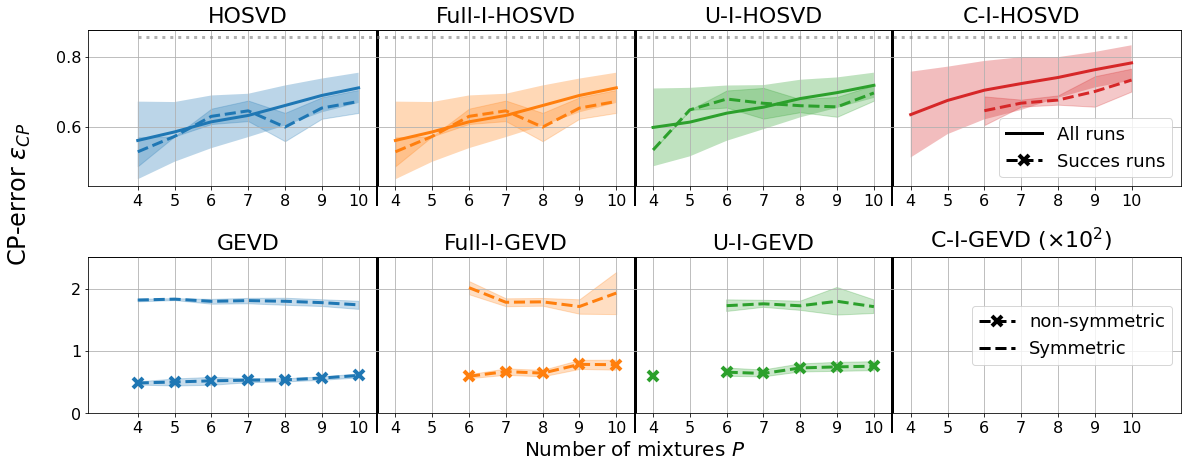

In [38]:
i = 0

# COmbine the all and success plots - FIRST RUN PREVIOUS CODE BOXES
# diag4 plot over all values for P
fig,ax = plt.subplots(2,1,figsize=[17,7])
fig.tight_layout(pad=5)
# ax[0].set_ylim([0,2.5])
ax[0].set_xticks([*range(len(Prange)*4)])
ax[1].set_xticks([*range(len(Prange)*4)])
ax[0].tick_params(which='major',axis='y',labelsize=16)
ax[1].tick_params(which='major',axis='y',labelsize=16)
ax[0].set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
ax[0].plot(range(len(Prange)),np.mean(CPD_errorHOSVD[i][0][0],axis=1),label='HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)),np.mean(CPD_errorHOSVD[i][0][0],axis=1)-np.std(CPD_errorHOSVD[i][0][0],axis=1),np.mean(CPD_errorHOSVD[i][0][0],axis=1)+np.std(CPD_errorHOSVD[i][0][0],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)),err_HOSVD_copy[i],label='HOSVD',linewidth=3,color=colors[0],linestyle='dashed')
ax[0].fill_between(range(len(Prange)),err_HOSVD_copy[i]-err_HOSVD_copy_std[i],err_HOSVD_copy[i]+err_HOSVD_copy_std[i],alpha=.25,color=colors[0])

ax[0].plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD_copy[i],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD_copy[i],axis=1)-np.std(diag4_IHOSVD_copy[i],axis=1),np.mean(diag4_IHOSVD_copy[i],axis=1)+np.std(diag4_IHOSVD_copy[i],axis=1),alpha=.3)
ax[0].plot(range(len(Prange),len(Prange)+len(Prange)),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange),len(Prange)+len(Prange)),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.25,color=colors[i+1])
i = 1
ax[0].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IHOSVD_copy[i],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IHOSVD_copy[i],axis=1)-np.std(diag4_IHOSVD_copy[i],axis=1),np.mean(diag4_IHOSVD_copy[i],axis=1)+np.std(diag4_IHOSVD_copy[i],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.25,color=colors[i+1])
i = 2
ax[0].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IHOSVD_copy[i],axis=1),label='I-HOSVD',linewidth=3)
ax[0].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IHOSVD_copy[i],axis=1)-np.std(diag4_IHOSVD_copy[i],axis=1),np.mean(diag4_IHOSVD_copy[i],axis=1)+np.std(diag4_IHOSVD_copy[i],axis=1),alpha=.3)
ax[0].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IHOSVD_copy[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[0].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IHOSVD_copy[i]-err_IHOSVD_copy_std[i],err_IHOSVD_copy[i]+err_IHOSVD_copy_std[i],alpha=.25,color=colors[i+1])

i = 0
ax[1].set_ylim([0,2.5])
ax[1].set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
# ax[1].plot(range(len(Prange)),np.mean(diag4_GEVD_copy[i][:,0,:],axis=1),label='HOSVD',linewidth=3,color=colors[0])
# ax[1].fill_between(range(len(Prange)),np.mean(diag4_GEVD_copy[i][:,0,:],axis=1)-np.std(diag4_GEVD_copy[i][:,0,:],axis=1),np.mean(diag4_GEVD_copy[i][:,0,:],axis=1)+np.std(diag4_GEVD_copy[i][:,0,:],axis=1),alpha=.3)
# ax[1].plot(range(len(Prange)),np.mean(diag4_GEVD_copy[i][:,1,:],axis=1),label='HOSVD',linewidth=3,color=colors[0])
# ax[1].fill_between(range(len(Prange)),np.mean(diag4_GEVD_copy[i][:,1,:],axis=1)-np.std(diag4_GEVD_copy[i][:,1,:],axis=1),np.mean(diag4_GEVD_copy[i][:,1,:],axis=1)+np.std(diag4_GEVD_copy[i][:,1,:],axis=1),alpha=.3)

ax[1].plot(range(len(Prange)),err_GEVD_copy1[i],label='HOSVD',linewidth=3,color=colors[0],linestyle='dashed')
ax[1].fill_between(range(len(Prange)),err_GEVD_copy1[i]-err_GEVD_copy_std1[i],err_GEVD_copy1[i]+err_GEVD_copy_std1[i],alpha=.25,color=colors[0])
ax[1].plot(range(len(Prange)),err_GEVD_copy2[i],label='HOSVD',linewidth=3,color=colors[0],linestyle='dashed',marker='x',markeredgewidth=4,markersize=10)
ax[1].fill_between(range(len(Prange)),err_GEVD_copy2[i]-err_GEVD_copy_std2[i],err_GEVD_copy2[i]+err_GEVD_copy_std2[i],alpha=.25,color=colors[0])

# p1, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD_copy[i][:,0,:],axis=1),label='I-HOSVD',linewidth=3,color=colors[i+1])
# ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD_copy[i][:,0,:],axis=1)-np.std(diag4_IGEVD_copy[i][:,0,:],axis=1),np.mean(diag4_IGEVD_copy[i][:,0,:],axis=1)+np.std(diag4_IGEVD_copy[i][:,0,:],axis=1),alpha=.3,color=colors[i+1])
# p1, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD_copy[i][:,1,:],axis=1),label='I-HOSVD',linewidth=3,color=colors[i+1])
# ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IGEVD_copy[i][:,1,:],axis=1)-np.std(diag4_IGEVD_copy[i][:,1,:],axis=1),np.mean(diag4_IGEVD_copy[i][:,1,:],axis=1)+np.std(diag4_IGEVD_copy[i][:,1,:],axis=1),alpha=.3,color=colors[i+1])
p1b, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy1[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy1[i]-err_IGEVD_copy_std1[i],err_IGEVD_copy1[i]+err_IGEVD_copy_std1[i],alpha=.25,color=colors[i+1])
p1b, = ax[1].plot(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy2[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed',marker='x',markeredgewidth=4,markersize=10)
ax[1].fill_between(range(len(Prange),len(Prange)+len(Prange)),err_IGEVD_copy2[i]-err_IGEVD_copy_std2[i],err_IGEVD_copy2[i]+err_IGEVD_copy_std2[i],alpha=.25,color=colors[i+1])
i = 1
# ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD_copy[i][:,0,:],axis=1),label='I-HOSVD',linewidth=3,color=colors[i+1])
# ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD_copy[i][:,0,:],axis=1)-np.std(diag4_IGEVD_copy[i][:,0,:],axis=1),np.mean(diag4_IGEVD_copy[i][:,0,:],axis=1)+np.std(diag4_IGEVD_copy[i][:,0,:],axis=1),alpha=.3,color=colors[i+1])
# ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD_copy[i][:,1,:],axis=1),label='I-HOSVD',linewidth=3,color=colors[i+1])
# ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_IGEVD_copy[i][:,1,:],axis=1)-np.std(diag4_IGEVD_copy[i][:,1,:],axis=1),np.mean(diag4_IGEVD_copy[i][:,0,:],axis=1)+np.std(diag4_IGEVD_copy[i][:,1,:],axis=1),alpha=.3,color=colors[i+1])
ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy1[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy1[i]-err_IGEVD_copy_std1[i],err_IGEVD_copy1[i]+err_IGEVD_copy_std1[i],alpha=.25,color=colors[i+1])
ax[1].plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy2[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed',marker='x',markeredgewidth=4,markersize=10)
ax[1].fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_IGEVD_copy2[i]-err_IGEVD_copy_std2[i],err_IGEVD_copy2[i]+err_IGEVD_copy_std2[i],alpha=.25,color=colors[i+1])
i = 2
sc = 0.1
# ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(sc*diag4_IGEVD_copy[i][:,0,:],axis=1),label='I-HOSVD',linewidth=3,color=colors[i+1])
# ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(sc*diag4_IGEVD_copy[i][:,0,:],axis=1)-np.std(sc*diag4_IGEVD_copy[i][:,0,:],axis=1),np.mean(sc*diag4_IGEVD_copy[i][:,0,:],axis=1)+np.std(sc*diag4_IGEVD_copy[i][:,0,:],axis=1),alpha=.3,color=colors[i+1])
ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),1000*np.mean(sc*diag4_IGEVD_copy[i][:,1,:],axis=1),label='I-HOSVD',linewidth=3,color=colors[i+1])
# ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(sc*diag4_IGEVD_copy[i][:,1,:],axis=1)-np.std(sc*diag4_IGEVD_copy[i][:,1,:],axis=1),np.mean(sc*diag4_IGEVD_copy[i][:,1,:],axis=1)+np.std(sc*diag4_IGEVD_copy[i][:,1,:],axis=1),alpha=.3,color=colors[i+1])
p2, = ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy1[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed')
ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy1[i]-err_IGEVD_copy_std1[i],err_IGEVD_copy1[i]+err_IGEVD_copy_std1[i],alpha=.25,color=colors[i+1])
p2B, = ax[1].plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy2[i],label='I-HOSVD',linewidth=3,color=colors[i+1],linestyle='dashed',marker='x',markeredgewidth=4,markersize=10)
ax[1].fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_IGEVD_copy2[i]-err_IGEVD_copy_std2[i],err_IGEVD_copy2[i]+err_IGEVD_copy_std2[i],alpha=.25,color=colors[i+1])
# ax[1].set_xlim(0,4*7)

ax[0].xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax[0].tick_params(which='minor',length=20,width=2)

ax[1].xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax[1].tick_params(which='minor',length=20,width=2)


plt.xlabel('Number of mixtures $P$',fontsize=20)
ax[0].set_ylabel('CP-error $\\varepsilon_{CP}$',fontsize=24)
ax[0].yaxis.set_label_coords(-0.05,-0.05)
# plt.ylabel('Measure of diagonality $\\tau_{D}$ \n of only $\hat{\mathbf{s}}$',fontsize=20)

ax[0].grid('on',which='minor',linewidth=3,color='k')
ax[0].grid('on',which='major')
ax[1].grid('on',which='minor',linewidth=3,color='k')
ax[1].grid('on',which='major')

secaxX1 = ax[0].secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['HOSVD','Full-I-HOSVD','U-I-HOSVD','C-I-HOSVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

secaxX1 = ax[1].secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24])
secaxX1.set_xticklabels(['GEVD','Full-I-GEVD','U-I-GEVD','C-I-GEVD $(\\times 10^2)$'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

ax[0].plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='gray',linestyle='dotted',linewidth=3,alpha=0.6)
# line1, = plt.plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='gray',linestyle='dotted',linewidth=3,alpha=0.6)

leg2 = ax[0].legend(handles=[p1,p1b],labels=['All runs','Succes runs'],fontsize=18,loc='lower right')
handles2 = leg2.legendHandles
handles2[0].set_color('k')
handles2[1].set_color('k')

leg3 = ax[1].legend(handles=[p2B,p2],labels=['non-symmetric','Symmetric'],fontsize=18,loc='center right')
handles3 = leg3.legendHandles
handles3[0].set_color('k')
handles3[1].set_color('k')
